## LDA Model Pipeline

In [161]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
import spacy

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [162]:
df_reviews = pd.read_parquet('../data/raw/reviews_2024-11-25_22-13_PH.parquet', engine = 'pyarrow')

In [163]:
df_reviews.shape

(120872, 12)

In [164]:
df_games = pd.read_parquet('../data/raw/games_2024-11-25_22-13_PH.parquet', engine = 'pyarrow')
df_games.head()

title                                        description                                    descriptionHTML                                            summary     installs  minInstalls  realInstalls     score  ratings  reviews                        histogram  price  free currency   sale saleTime originalPrice saleText  offersIAP inAppProductPrice      developer          developerId                developerEmail             developerWebsite                                 developerAddress                                      privacyPolicy        genre           genreId                                         categories                                               icon                                        headerImage                                        screenshots                                              video                                         videoImage contentRating contentRatingDescription  adSupported  containsAds      released  \
0    ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...  https://play-lh.googleusercontent.com/dubBqdZf...  https://play-lh.googleusercontent.com/n-zUelbp...  [https://play-lh.googleusercontent.com/9KXm1Nz...  https://www.youtube.com/embed/MuBvRlbNCVM?ps=p...  https://play-lh.googleusercontent.com/n-zUelbp...      Everyone                     None        False        False   Mar 3, 2016   
1              PBS KIDS Games App  The PBS KIDS Games app makes learning fun and ...  The PBS KIDS Games app makes learning fun and ...  Play safe educational games & learn with Danie...  10,000,000+     10000000      12752626  4.370655    48187    11756  [4111, 1845, 2095, 4151, 35982]    0.0  True      USD  False     None          None     None      False              None       PBS KIDS  8332149447945516079            AndroidApp@pbs.org      http://pbskids.org/apps        1225 South Clark St.\nArlington, VA 22202                        http://pbskids.org/privacy/  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...  https://play-lh.googleusercontent.com/nYDg7dx-...  https://play-lh.googleusercontent.com/WVlMU0zL...  [https://play-lh.googleusercontent.com/cFSmqn4...                                               None                                               None      Everyone                     None        False        False  Apr 27, 2016   
2  Math Kids: Math Games For Kids  It's never too early to start your child's edu...  It&#39;s never too early to start your child&#...  Fun game for preschoolers to learn addition, s...  50,000,000+     50000000      57606406  4.636363    52129      902  [2364, 1112, 1251, 3616, 43756]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...  https://play-lh.googleusercontent.com/NXJdwPiM...  https://play-lh.googleusercontent.com/AdqBNSHK...  [https://play-lh.googleusercontent.com/xirdeXt...  https://www.youtube.com/embed/rbL9Fr6enVw?ps=p...  https://play-lh.googleusercontent.com/AdqBNSHK...      Everyone                     None        False        False  Aug 22, 2017   
3  Spelling & Phonics: Kids Games  Ready to play a truly fre

In [165]:
filtered_df = df_reviews.loc[((df_reviews['content'].fillna('').str.split().apply(len) >= 3) & (df_reviews['thumbsUpCount'] >= 10)) | ((df_reviews['content'].fillna('').str.split().apply(len) >= 6) & (pd.notnull(df_reviews['replyContent']))),
                             ['content','reviewId','appId','userName','score','thumbsUpCount','replyContent']]

In [166]:
filtered_df.shape

(22382, 7)

Function for preprocessing data for topic modeling.

In [167]:
import subprocess

def lemmatization(document, model):
    return " ".join([token.lemma_ for token in model(document)])

def named_entities(document, model):
    # return list(model(document).ents)
    return [ent.text for ent in model(document).ents]

def remove_stop_words(tokens_list, stop_words):
    return [token for token in tokens_list if token not in stop_words]

def remove_one_character_or_letter_tokens(tokens_list):
    return [token for token in tokens_list if token.isalpha() and not (len(token) >= 2 and len(set(token)) == 1)]

def preprocess_dataframe(dataframe, text_column):
    # nltk, spacy required resources
    required_resources = ['stopwords', 'punkt']
    for resource in required_resources:
        try:
            nltk.data.find(f"corpora/{resource}")
        except LookupError:
            nltk.download(resource)
    try:
        nlp_spacy = spacy.load('en_core_web_sm')
    except OSError:
        print("spaCy model 'en_core_web_sm' not found. Downloading now...")
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'], check=True)
        nlp_spacy = spacy.load('en_core_web_sm')

    data = dataframe.copy()
    row_docs = data[text_column].fillna('').apply(lambda x: lemmatization(x, nlp_spacy))
    data['reviews_NER'] = row_docs.apply(lambda x: named_entities(x, nlp_spacy))
    row_docs = row_docs.str.lower().apply(word_tokenize)

    stop_words = set(stopwords.words('english'))
    row_docs = row_docs.apply(lambda x: remove_stop_words(x, stop_words))
    row_docs = row_docs.apply(remove_one_character_or_letter_tokens)

    data['processed_reviews'] = row_docs + data['reviews_NER']
    return data

In [168]:
filtered_df.head()

content                              reviewId                                              appId              userName  score  thumbsUpCount                                       replyContent
11  Wrong pronunciation of punjabi alphabets. Kind...  3718e0b9-3994-42aa-b07d-268e2fd18c98  com.rvappstudios.abc_kids_toddler_tracing_phonics          Ranjit Singh      1              0  We've forwarded your feedback to our developer...
16  My daughter loves this app and has learned so ...  7f0129ac-adbc-4daa-93bc-e757de8eaca4  com.rvappstudios.abc_kids_toddler_tracing_phonics     Claudia Rodriguez      5             14                                               None
21  For the first time ever, my 6 old autistic son...  f9139c1f-08db-4802-a6c2-69622855ebf0  com.rvappstudios.abc_kids_toddler_tracing_phonics  Hanaa zakawat Husain      5             27  Thank you for sharing your review, it's review...
64  Love this game! I love this letter tracing gam...  676c0171-2ad4-46a3-b8cb-6b1bd597a37b  com.rvappstudios.abc_kids_toddler_tracing_phonics     stephanie johnson      5            128                                               None
81  For a Afrikaans speaking person. Thank you so ...  a7ac0397-aec6-40c8-b74d-74052ec8b68e  com.rvappstudios.abc_kids_toddler_tracing_phonics      Elizma Pretorius      5             89  So happy to read the app.has helped. The revie...

In [169]:
preprocess_df = preprocess_dataframe(filtered_df, 'content')
preprocess_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mund\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


content                              reviewId                                              appId              userName  score  thumbsUpCount                                       replyContent                         reviews_NER                                  processed_reviews
11  Wrong pronunciation of punjabi alphabets. Kind...  3718e0b9-3994-42aa-b07d-268e2fd18c98  com.rvappstudios.abc_kids_toddler_tracing_phonics          Ranjit Singh      1              0  We've forwarded your feedback to our developer...                                  []  [wrong, pronunciation, punjabi, alphabet, kind...
16  My daughter loves this app and has learned so ...  7f0129ac-adbc-4daa-93bc-e757de8eaca4  com.rvappstudios.abc_kids_toddler_tracing_phonics     Claudia Rodriguez      5             14                                               None                                  []  [daughter, love, app, learn, much, recognize, ...
21  For the first time ever, my 6 old autistic son...  f9139c1f-08db-4802-a6c2-69622855ebf0  com.rvappstudios.abc_kids_toddler_tracing_phonics  Hanaa zakawat Husain      5             27  Thank you for sharing your review, it's review...                     [first, 6, God]  [first, time, ever, old, autistic, son, look, ...
64  Love this game! I love this letter tracing gam...  676c0171-2ad4-46a3-b8cb-6b1bd597a37b  com.rvappstudios.abc_kids_toddler_tracing_phonics     stephanie johnson      5            128                                               None                                  []  [love, game, love, letter, trace, game, beauti...
81  For a Afrikaans speaking person. Thank you so ...  a7ac0397-aec6-40c8-b74d-74052ec8b68e  com.rvappstudios.abc_kids_toddler_tracing_phonics      Elizma Pretorius      5             89  So happy to read the app.has helped. The revie...  [Afrikaans, afrikaans, 2 year old]  [afrikaans, speak, person, thank, much, add, l...

Apply Tuned Topic Modeling

In [170]:
copy_df = preprocess_df.copy()
docs = copy_df['processed_reviews']

dictionary = Dictionary(docs.tolist())
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in docs.tolist()]

lda_model = LdaModel(corpus, id2word=dictionary, passes=10, random_state=77, chunksize=200, 
                            num_topics = 4, alpha= 0.1,  eta = 2)
coherence_model = CoherenceModel(model = lda_model, texts = docs.tolist(), 
                                        dictionary=dictionary, coherence= 'c_v')



In [171]:
topics_weights_df = pd.DataFrame([dict(lda_model.get_document_topics(bow, minimum_probability=0.0)) for bow in corpus])
topics_weights_df['dominant_topic'] = topics_weights_df.idxmax(axis = 1)
topics_weights_df.head()

0         1         2         3  dominant_topic
0  0.013532  0.251787  0.721148  0.013533               2
1  0.008779  0.973662  0.008781  0.008778               1
2  0.426376  0.320908  0.248613  0.004103               0
3  0.006103  0.569606  0.006104  0.418186               1
4  0.005157  0.984529  0.005157  0.005157               1

In [172]:
topic_and_labeled_df = pd.concat([preprocess_df.reset_index(drop=True),topics_weights_df.reset_index(drop=True)], axis = 1)
topic_and_labeled_df.head(3)

content                              reviewId                                              appId              userName  score  thumbsUpCount                                       replyContent      reviews_NER                                  processed_reviews         0         1         2         3  dominant_topic
0  Wrong pronunciation of punjabi alphabets. Kind...  3718e0b9-3994-42aa-b07d-268e2fd18c98  com.rvappstudios.abc_kids_toddler_tracing_phonics          Ranjit Singh      1              0  We've forwarded your feedback to our developer...               []  [wrong, pronunciation, punjabi, alphabet, kind...  0.013532  0.251787  0.721148  0.013533               2
1  My daughter loves this app and has learned so ...  7f0129ac-adbc-4daa-93bc-e757de8eaca4  com.rvappstudios.abc_kids_toddler_tracing_phonics     Claudia Rodriguez      5             14                                               None               []  [daughter, love, app, learn, much, recognize, ...  0.008779  0.973662  0.008781  0.008778               1
2  For the first time ever, my 6 old autistic son...  f9139c1f-08db-4802-a6c2-69622855ebf0  com.rvappstudios.abc_kids_toddler_tracing_phonics  Hanaa zakawat Husain      5             27  Thank you for sharing your review, it's review...  [first, 6, God]  [first, time, ever, old, autistic, son, look, ...  0.426376  0.320908  0.248613  0.004103               0

In [173]:
combined_df = topic_and_labeled_df.merge(df_games,how = 'left', on = 'appId')
combined_df.head(3)

content                              reviewId                                              appId              userName  score_x  thumbsUpCount                                       replyContent      reviews_NER                                  processed_reviews         0         1         2         3  dominant_topic                         title                                        description                                    descriptionHTML                                            summary     installs  minInstalls  realInstalls   score_y  ratings  reviews                        histogram  price  free currency   sale saleTime originalPrice saleText  offersIAP inAppProductPrice      developer          developerId                developerEmail             developerWebsite                                 developerAddress                                      privacyPolicy        genre           genreId  \
0  Wrong pronunciation of punjabi alphabets. Kind...  3718e0b9-3994-42aa-b07d-268e2fd18c98  com.rvappstudios.abc_kids_toddler_tracing_phonics          Ranjit Singh        1              0  We've forwarded your feedback to our developer...               []  [wrong, pronunciation, punjabi, alphabet, kind...  0.013532  0.251787  0.721148  0.013533               2  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   
1  My daughter loves this app and has learned so ...  7f0129ac-adbc-4daa-93bc-e757de8eaca4  com.rvappstudios.abc_kids_toddler_tracing_phonics     Claudia Rodriguez        5             14                                               None               []  [daughter, love, app, learn, much, recognize, ...  0.008779  0.973662  0.008781  0.008778               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   
2  For the first time ever, my 6 old autistic son...  f9139c1f-08db-4802-a6c2-69622855ebf0  com.rvappstudios.abc_kids_toddler_tracing_phonics  Hanaa zakawat Husain        5             27  Thank you for sharing your review, it's review...  [first, 6, God]  [first, time, ever, old, autistic, son, look, ...  0.426376  0.320908  0.248613  0.004103               0  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   

                                          categories                                               icon                                        headerImage                          

Review Likes on filtered data

In [174]:
combined_df.isna().sum()

content                         0
reviewId                        0
appId                           0
userName                        0
score_x                         0
thumbsUpCount                   0
replyContent                 2977
reviews_NER                     0
processed_reviews               0
0                               0
1                               0
2                               0
3                               0
dominant_topic                  0
title                           0
description                     0
descriptionHTML                 0
summary                         0
installs                        0
minInstalls                     0
realInstalls                    0
score_y                         0
ratings                         0
reviews                         0
histogram                       0
price                           0
free                            0
currency                        0
sale                            0
saleTime      

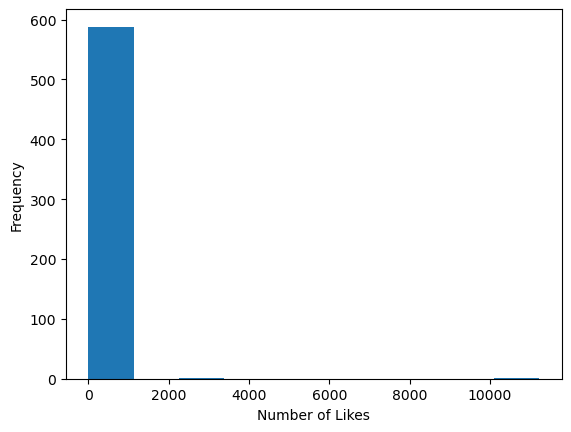

In [175]:
combined_df['thumbsUpCount'].value_counts().plot(kind = 'hist')
plt.xlabel('Number of Likes')
plt.show()

Lets make a granular version of its distribution.

### Approach 2

Since the data is heavily skewed, we visualize the data using log transform.  

In [176]:
# Applying Log Transform with + 1 to eliminate -inf values
np.log(combined_df['thumbsUpCount'] + 1)

0        0.000000
1        2.708050
2        3.332205
3        4.859812
4        4.499810
           ...   
22377    2.564949
22378    3.610918
22379    2.564949
22380    6.459904
22381    2.944439
Name: thumbsUpCount, Length: 22382, dtype: float64

In [177]:
# 95th percentile of data
print(f"95th percentile of likes data: {combined_df['thumbsUpCount'].quantile(0.95)} ")
print(f"95th percentile of log-transformed data: {np.log(combined_df['thumbsUpCount'] + 1).quantile(0.95)} ")


95th percentile of likes data: 99.0 
95th percentile of log-transformed data: 4.605170185988092 


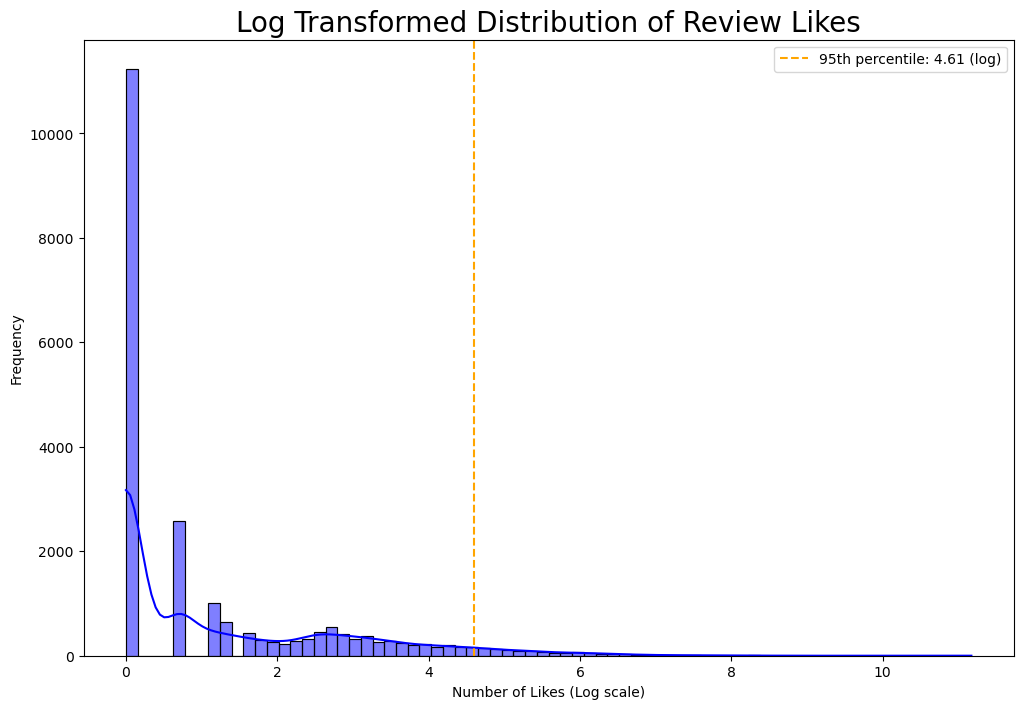

In [178]:
percentile_95 = np.log(combined_df['thumbsUpCount'] + 1).quantile(0.95) 

fig, ax = plt.subplots(figsize= (12,8))
sns.histplot(np.log(combined_df['thumbsUpCount'] + 1), kde = True, color = 'blue')
plt.axvline(percentile_95, color = 'orange', linestyle='--', label = f"95th percentile: {percentile_95:.2f} (log)")
plt.xlabel('Number of Likes (Log scale)')
plt.ylabel('Frequency')
plt.title('Log Transformed Distribution of Review Likes', size = 20)
plt.legend()
plt.show()


The 95th percentile of the data being 99 likes means that 95% of the users have fewer than 99 likes. This suggest that users with 100 likes or more are most likely to represent top segment who has stronger influence due to higher likes engagement. 

In [179]:
combined_df[(combined_df['thumbsUpCount'] > combined_df['thumbsUpCount'].quantile(0.95))].shape

(1115, 58)

Now, 1115 reviews of influential users for 94 apps.

In [180]:
combined_df[(combined_df['thumbsUpCount'] > combined_df['thumbsUpCount'].quantile(0.95))]['appId'].value_counts().sort_values()

appId
com.dts.freefiremax                                                               1
com.GalacticSlice.OneBitAdventure                                                 1
com.artifexmundi.mopa1.gp                                                         1
com.mrswordsmith.WordTag                                                          1
com.joongly.kids.learning.games                                                   1
com.dts.freefireth                                                                2
com.zeptolab.bulletecho.google                                                    2
com.kids.learn.reading.app                                                        2
com.zynga.starwars.hunters                                                        2
com.PoxelStudios.DudeTheftAuto                                                    2
com.tencent.ig                                                                    2
com.madfingergames.legends                                            

### EDA Topic Weignts on Influential Users

In [181]:
final_df = combined_df[(combined_df['thumbsUpCount'] > combined_df['thumbsUpCount'].quantile(0.95))].copy()
final_df.head(3)

content                              reviewId                                              appId           userName  score_x  thumbsUpCount replyContent                reviews_NER                                  processed_reviews         0         1         2         3  dominant_topic                         title                                        description                                    descriptionHTML                                            summary     installs  minInstalls  realInstalls   score_y  ratings  reviews                        histogram  price  free currency   sale saleTime originalPrice saleText  offersIAP inAppProductPrice      developer          developerId                developerEmail             developerWebsite                                 developerAddress                                      privacyPolicy        genre           genreId                                         categories  \
3   Love this game! I love this letter tracing gam...  676c0171-2ad4-46a3-b8cb-6b1bd597a37b  com.rvappstudios.abc_kids_toddler_tracing_phonics  stephanie johnson        5            128         None                         []  [love, game, love, letter, trace, game, beauti...  0.006103  0.569606  0.006104  0.418186               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...   
17  amazing app! you can't ignore the fact they ma...  e623136b-7d0c-4714-9c8c-26904dd8b924  com.rvappstudios.abc_kids_toddler_tracing_phonics       Reem Beddawi        5            175         None                         []  [amazing, app, ignore, fact, make, great, app,...  0.004278  0.987166  0.004278  0.004278               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...   
19  3 year old plays many of your apps he loves th...  9d391d86-096d-47c6-80a2-a896658473f9  com.rvappstudios.abc_kids_toddler_tracing_phonics       john cushard        5            225         None  [3 year old, 75 year old]  [year, old, play, many, app, love, learn, make...  0.003939  0.823458  0.168663  0.003939               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL  [{'id': 'GAME_EDUCATIONAL', 'name': 'Education...   

                                                 icon                                        head

In [182]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1115 entries, 3 to 22380
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   content                   1115 non-null   object 
 1   reviewId                  1115 non-null   object 
 2   appId                     1115 non-null   object 
 3   userName                  1115 non-null   object 
 4   score_x                   1115 non-null   int64  
 5   thumbsUpCount             1115 non-null   int64  
 6   replyContent              520 non-null    object 
 7   reviews_NER               1115 non-null   object 
 8   processed_reviews         1115 non-null   object 
 9   0                         1115 non-null   float32
 10  1                         1115 non-null   float32
 11  2                         1115 non-null   float32
 12  3                         1115 non-null   float32
 13  dominant_topic            1115 non-null   int64  
 14  title       

### Topics Definition and Distribution of Dominant Topics

c:\Users\Mund\Anaconda3\envs\nlp_env\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


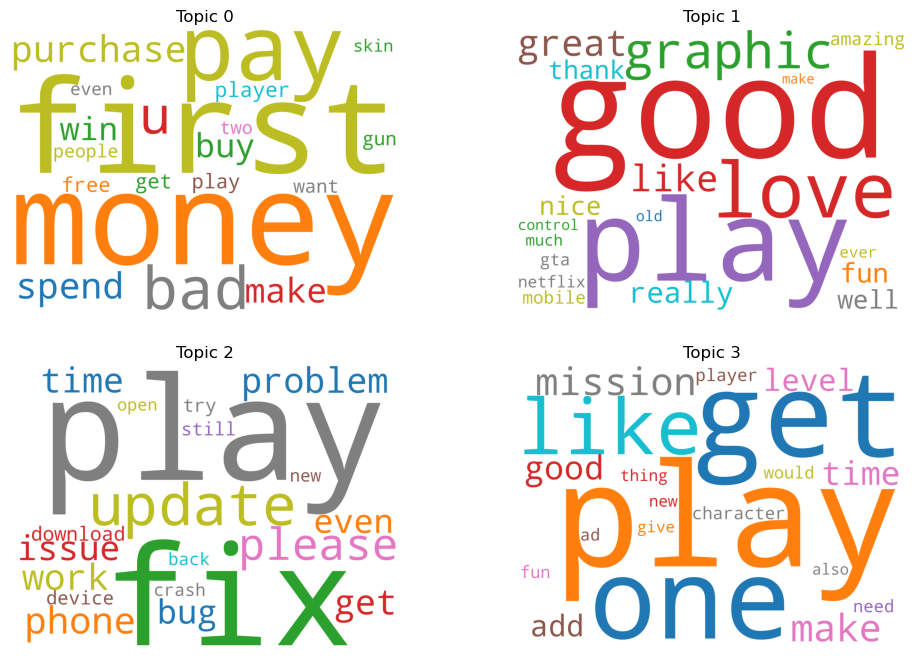

In [183]:
from wordcloud import WordCloud

topics_dict = dict(lda_model.show_topics(formatted=False, num_words=50))

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  prefer_horizontal=1.0)

fig, ax = plt.subplots(2, 2, figsize = (12,8))

ax[0,0].imshow(cloud.generate_from_frequencies(dict(topics_dict[0])))
ax[0,0].set_title('Topic 0')
ax[0,0].axis('off')
ax[0,1].imshow(cloud.generate_from_frequencies(dict(topics_dict[1])))
ax[0,1].set_title('Topic 1')
ax[0,1].axis('off')
ax[1,0].imshow(cloud.generate_from_frequencies(dict(topics_dict[2])))
ax[1,0].set_title('Topic 2')
ax[1,0].axis('off')
ax[1,1].imshow(cloud.generate_from_frequencies(dict(topics_dict[3])))
ax[1,1].set_title('Topic 3')
ax[1,1].axis('off')
plt.show()



### Save wordcloud topics in Images folder

topic_0 saved..
topic_1 saved..
topic_2 saved..
topic_3 saved..


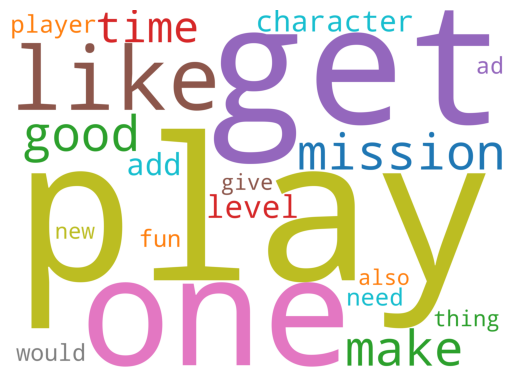

In [184]:
for i in range(4):
    plt.imshow(cloud.generate_from_frequencies(dict(topics_dict[i])))
    plt.axis('off')
    plt.savefig(f'../images/topic_{i}.png')
    print(f'topic_{i} saved..')

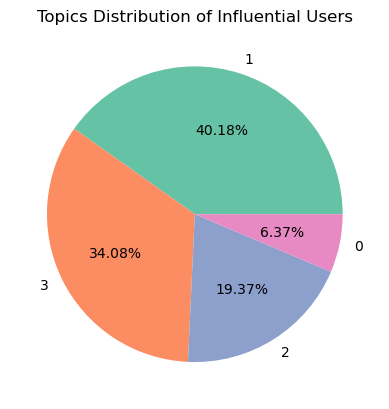

In [185]:
dominant_topics_dist = 100*final_df['dominant_topic'].value_counts()/final_df.shape[0]
plt.pie(dominant_topics_dist, labels = dominant_topics_dist.index, autopct='%0.2f%%', colors=sns.color_palette('Set2')) 
plt.title('Topics Distribution of Influential Users')
plt.show()

Features Check

In [186]:
# Take note that some of these columns are 
for feat in final_df.columns:
    if feat not in ['processed_reviews','reviews_NER','content','reviewid','comments', 'replyContent',0,1,2,3,4, 'histogram', 'categories','screenshots']:
        print(f"FEATURE_NAME: {feat}, # of unique values: {final_df[feat].nunique()}, \n - Sample Values: {final_df[feat].unique().tolist()[:3]}")

FEATURE_NAME: reviewId, # of unique values: 1115, 
 - Sample Values: ['676c0171-2ad4-46a3-b8cb-6b1bd597a37b', 'e623136b-7d0c-4714-9c8c-26904dd8b924', '9d391d86-096d-47c6-80a2-a896658473f9']
FEATURE_NAME: appId, # of unique values: 78, 
 - Sample Values: ['com.rvappstudios.abc_kids_toddler_tracing_phonics', 'org.pbskids.gamesapp', 'com.rvappstudios.math.kids.counting']
FEATURE_NAME: userName, # of unique values: 1061, 
 - Sample Values: ['stephanie johnson', 'Reem Beddawi', 'john cushard']
FEATURE_NAME: score_x, # of unique values: 5, 
 - Sample Values: [5, 4, 1]
FEATURE_NAME: thumbsUpCount, # of unique values: 490, 
 - Sample Values: [128, 175, 225]
FEATURE_NAME: dominant_topic, # of unique values: 4, 
 - Sample Values: [1, 2, 3]
FEATURE_NAME: title, # of unique values: 78, 
 - Sample Values: ['ABC Kids - Tracing & Phonics', 'PBS KIDS Games App', 'Math Kids: Math Games For Kids']
FEATURE_NAME: description, # of unique values: 78, 
 - Sample Values: ["Looking for a fun, free, and simple

Notes: 
- In doing analysis, better use App Title rather than AppId.
- description and descriptionHTML has the same content of text.
- Features game name, installs, overall_rating, free, developer, genre, ContentRatingDescription, contentRating and containsAd are the features that we could explore are analysis of influential users topics. Columns that are not mentioned does not contain that much of information to perform analysis further. 

#### Topics Distribution Per Genre

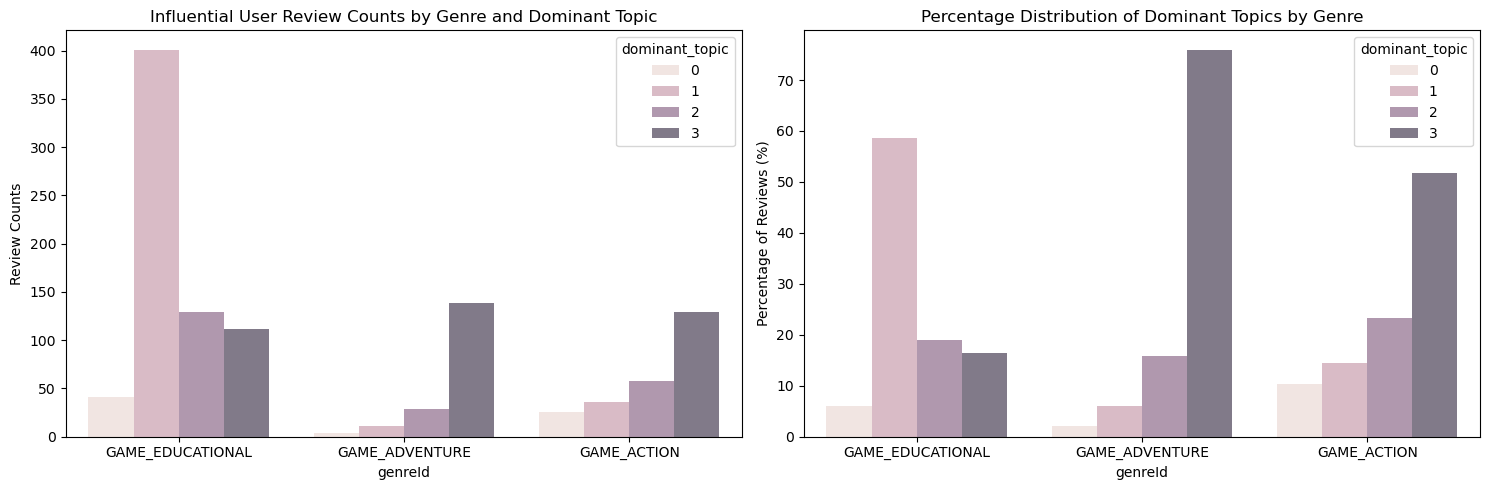

In [187]:
genre_plot = final_df[['dominant_topic','genreId']].value_counts().reset_index()
genre_plot['genre_pct'] = 100*genre_plot['count']/genre_plot.groupby('genreId')['count'].transform('sum')
fig, ax = plt.subplots(1,2, figsize = (15,5))
g = sns.barplot(data = genre_plot,  x = 'genreId', y = 'count', hue = 'dominant_topic', 
                errorbar=None, alpha  = .6, ax = ax[0])
g.set_ylabel('Review Counts')
g.set_title('Influential User Review Counts by Genre and Dominant Topic')
g = sns.barplot(data = genre_plot,  x = 'genreId', y = 'genre_pct', hue = 'dominant_topic', 
                errorbar=None, alpha  = .6, ax = ax[1])
g.set_ylabel('Percentage of Reviews (%)')
g.set_title('Percentage Distribution of Dominant Topics by Genre')
plt.tight_layout()
plt.show()

#### Topics Distribution Per Game

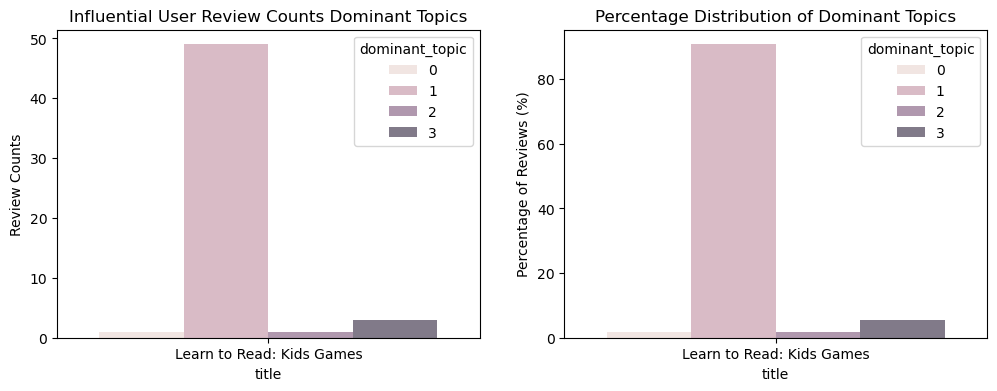

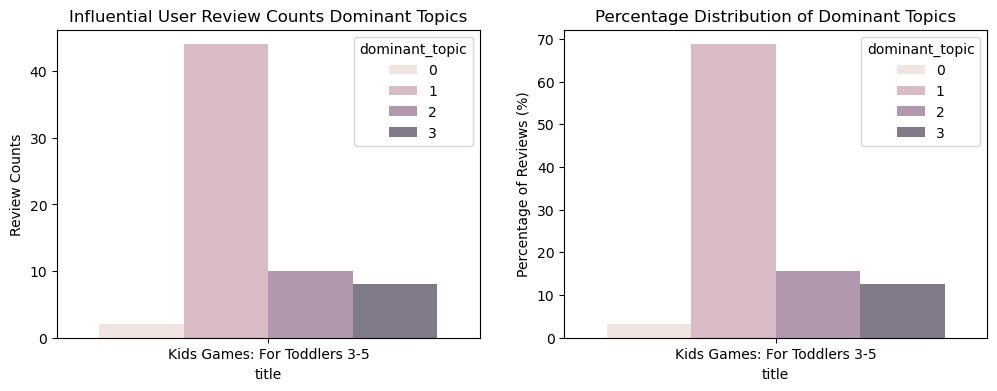

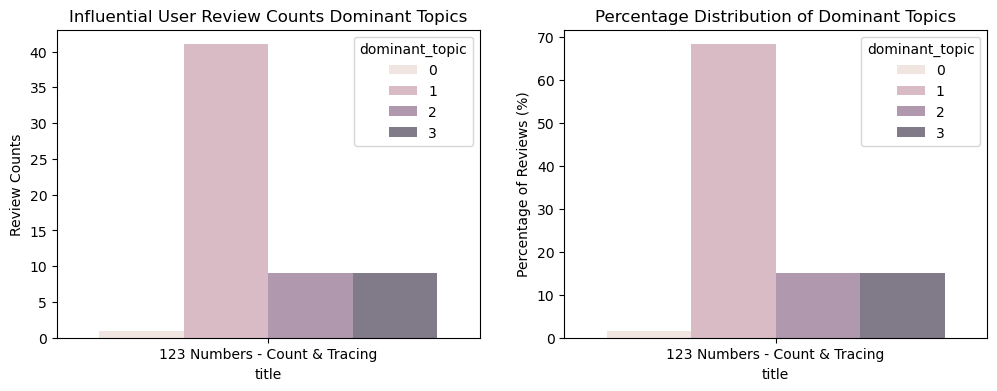

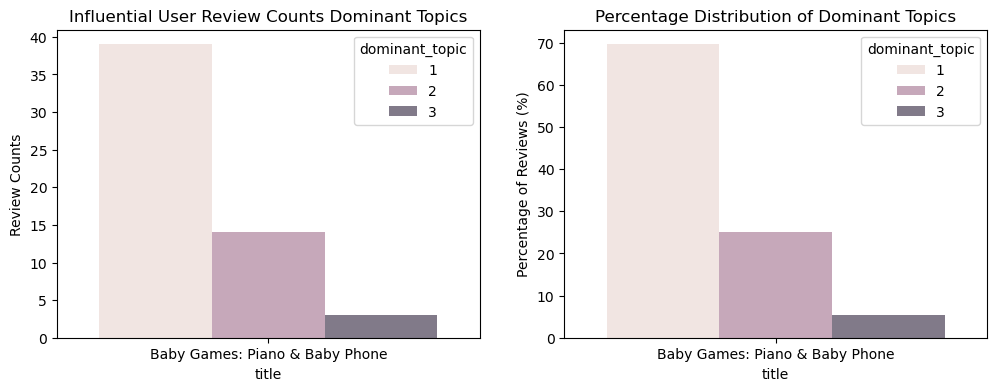

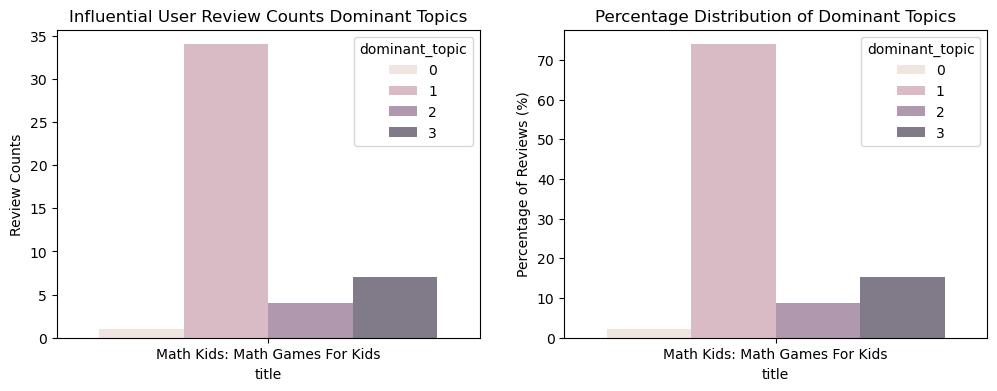

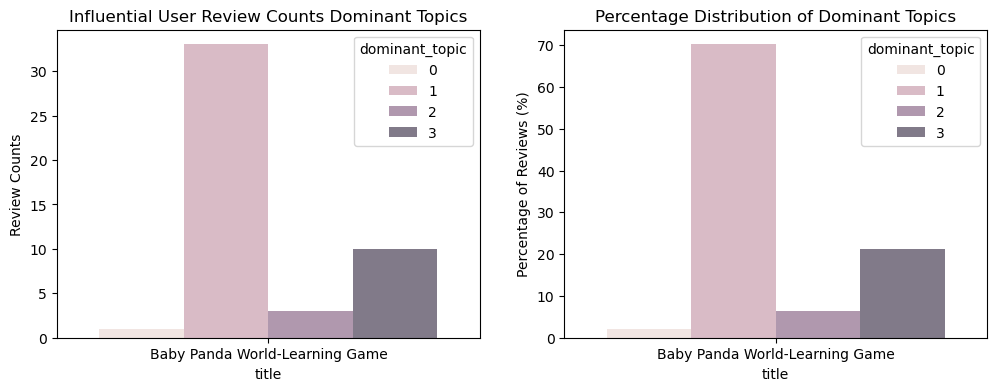

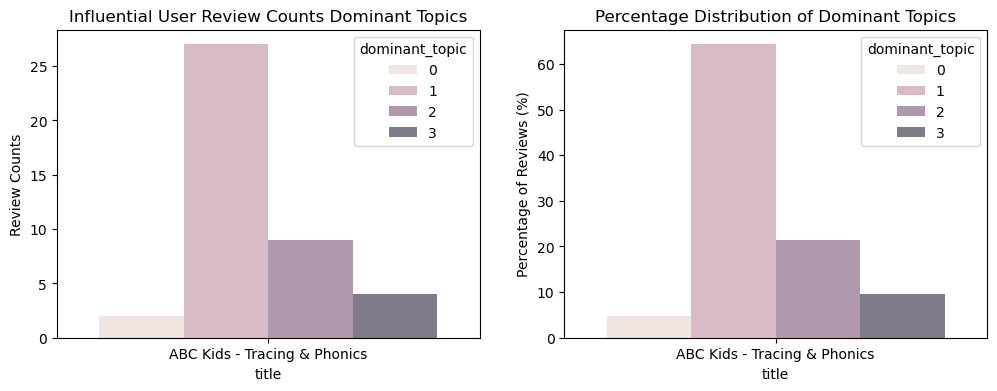

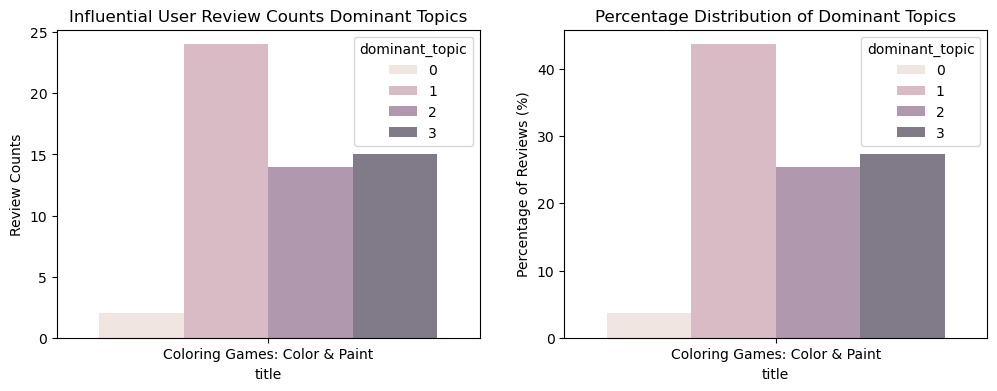

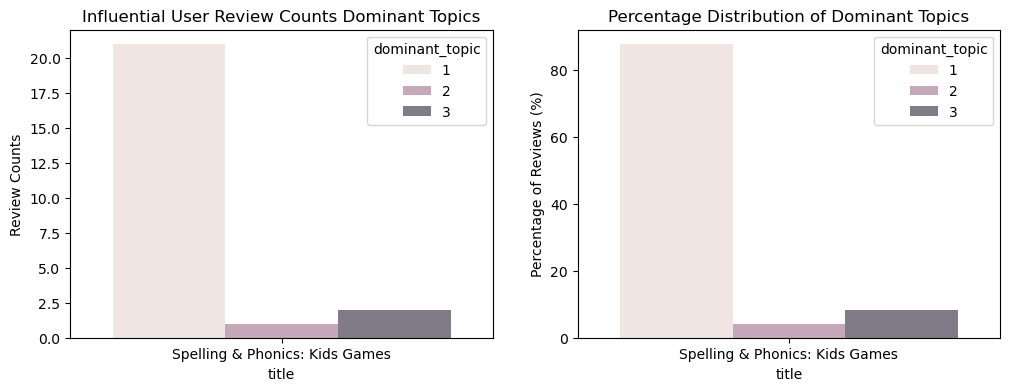

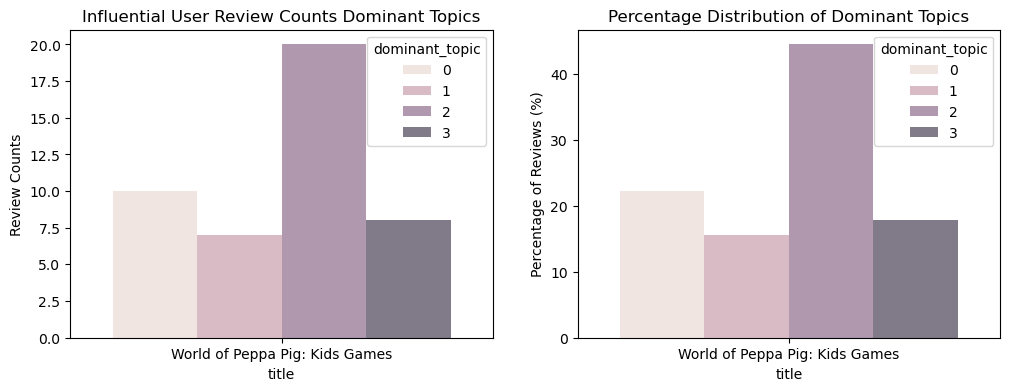

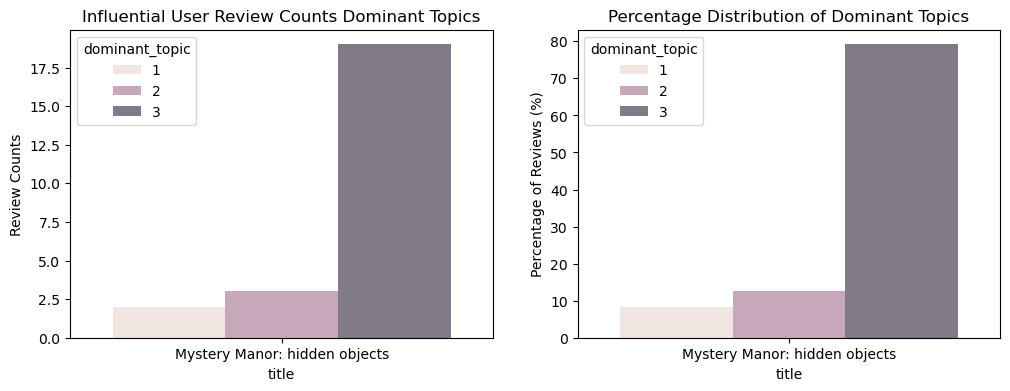

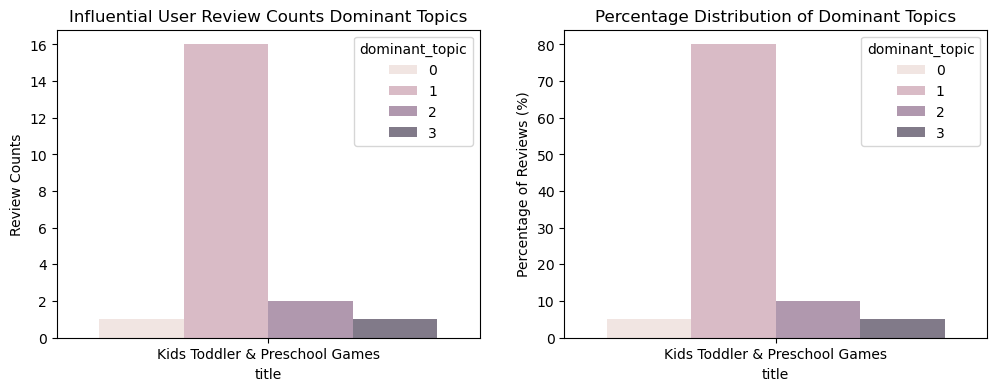

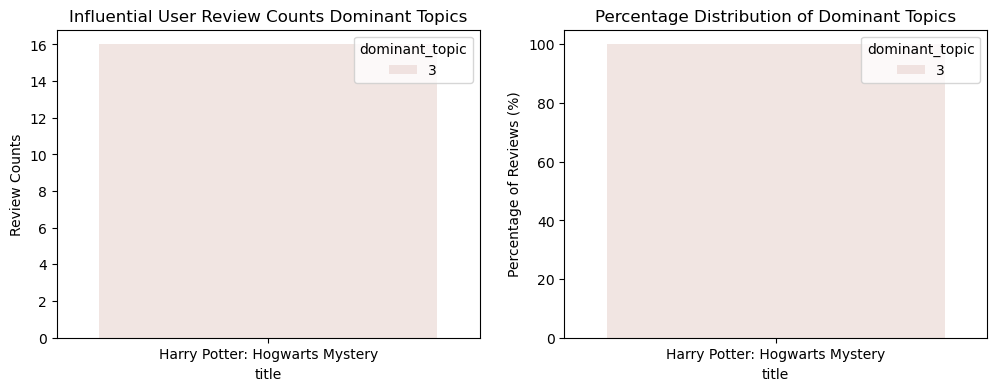

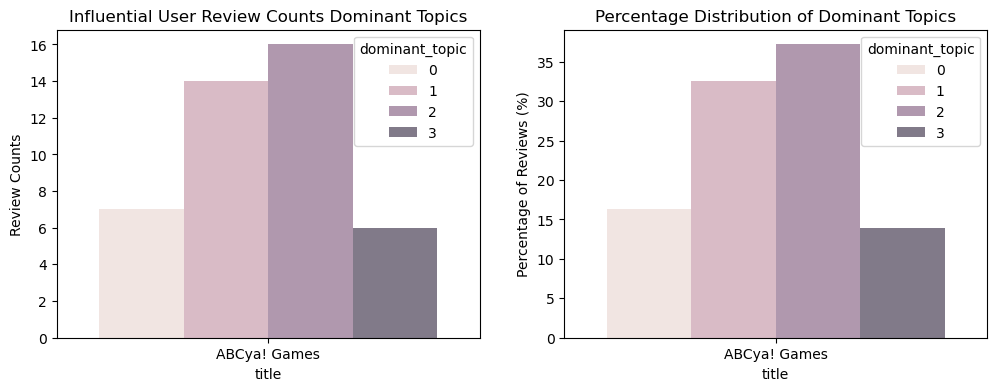

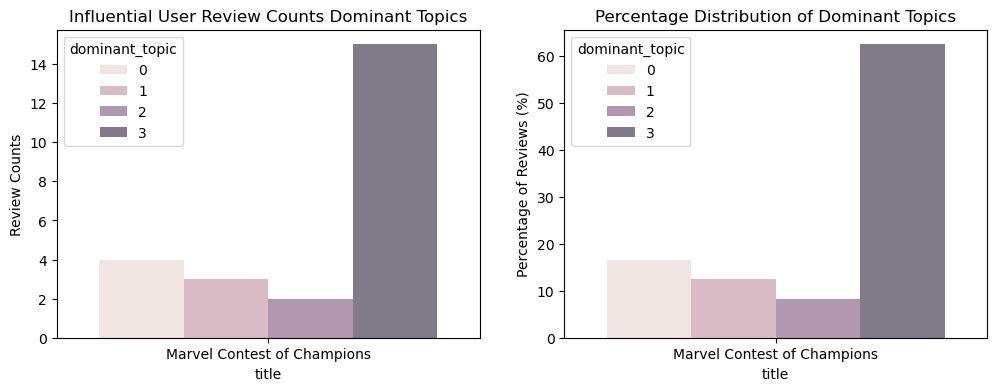

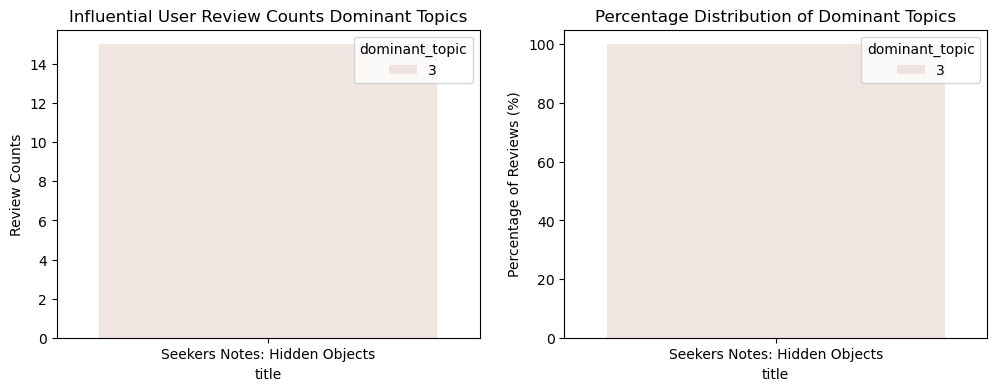

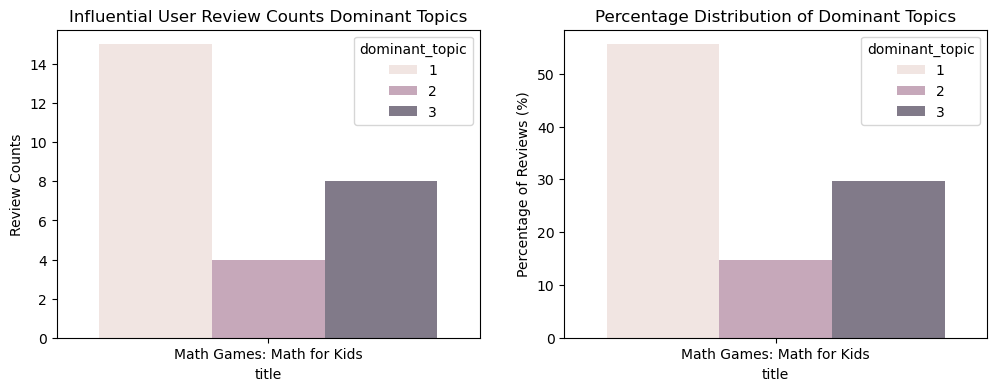

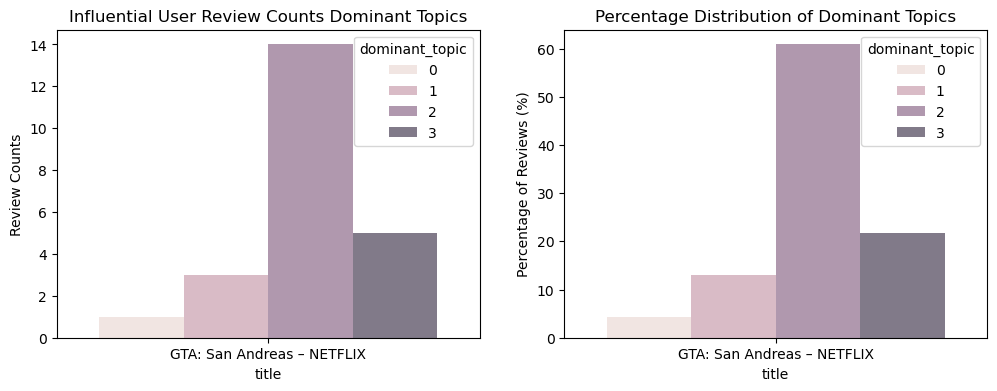

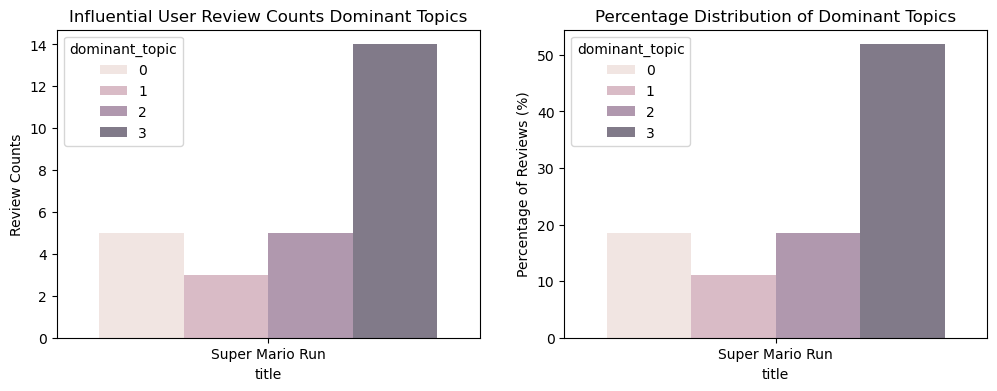

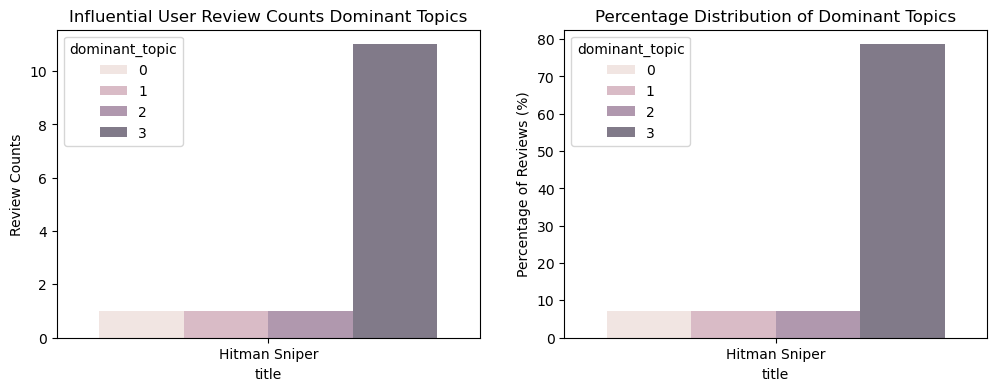

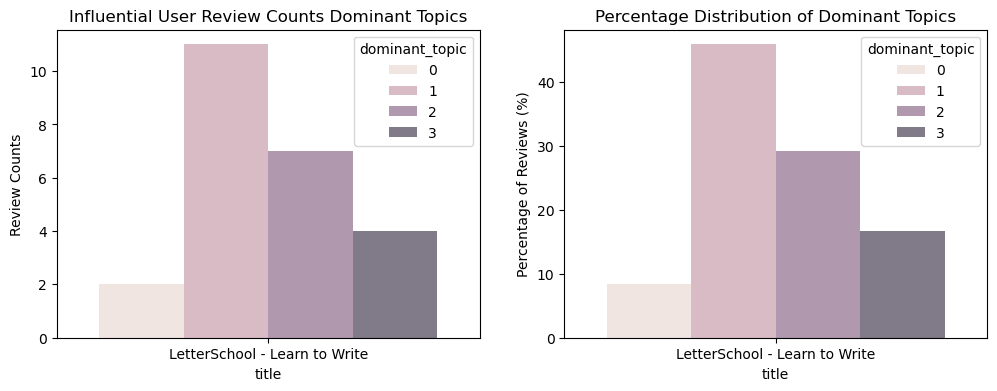

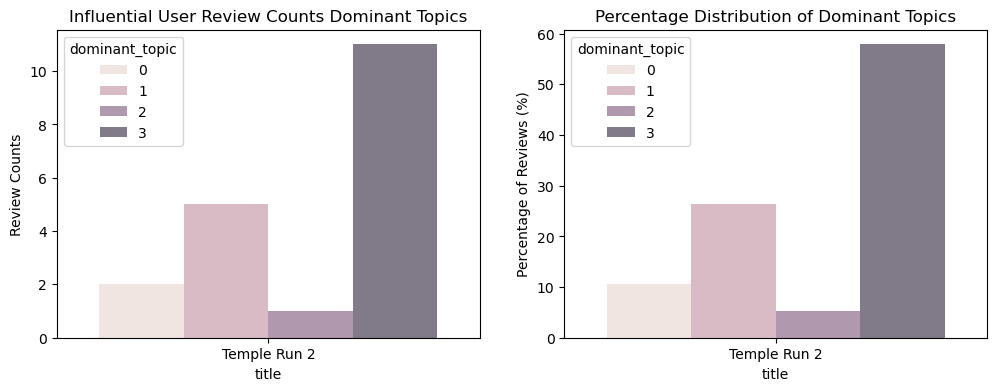

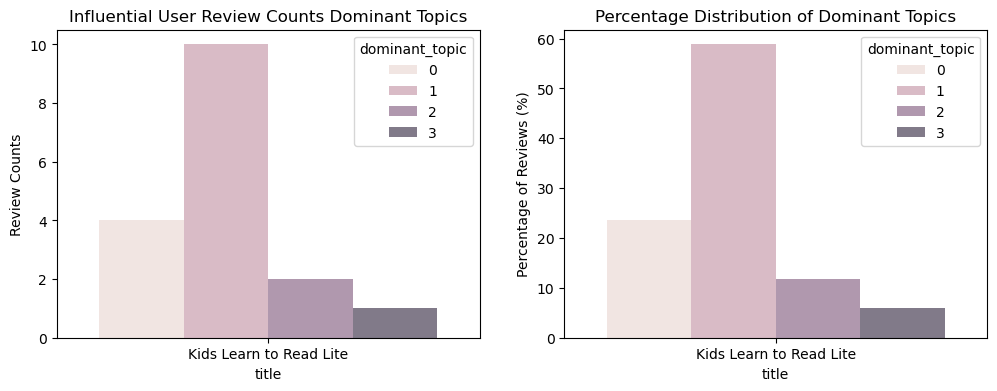

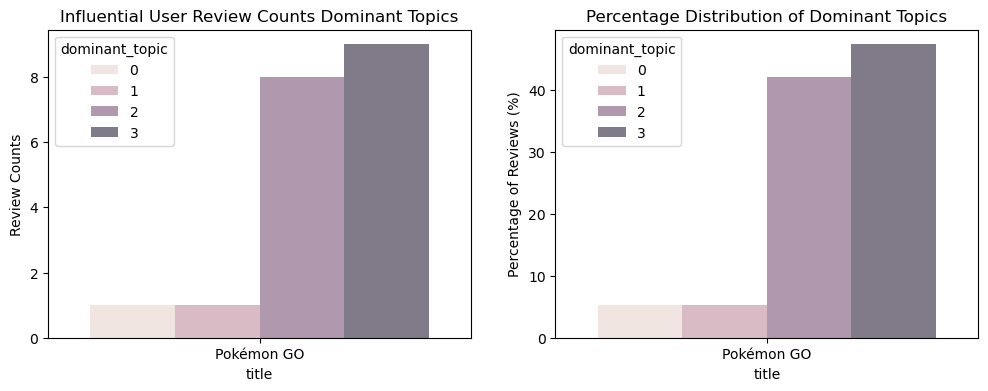

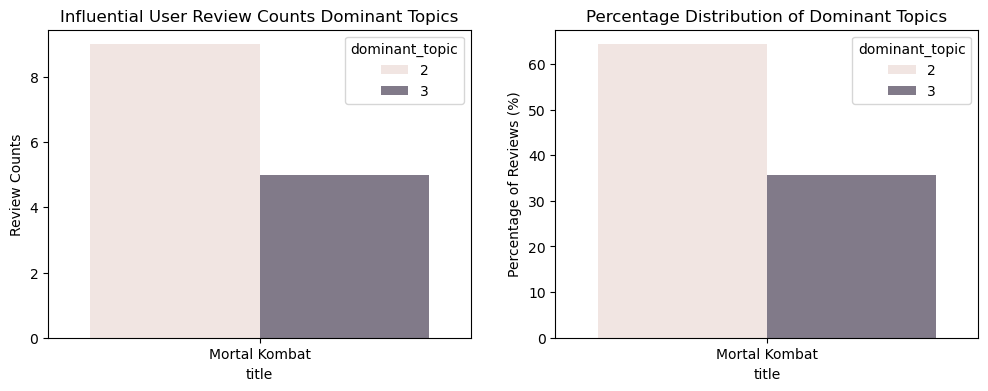

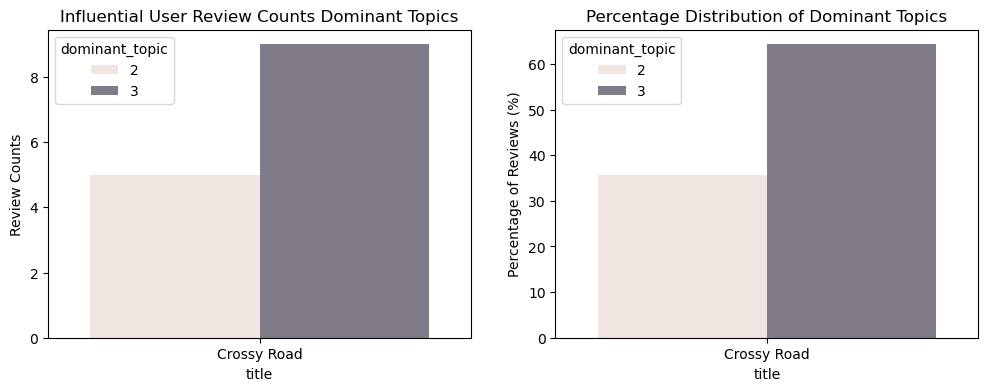

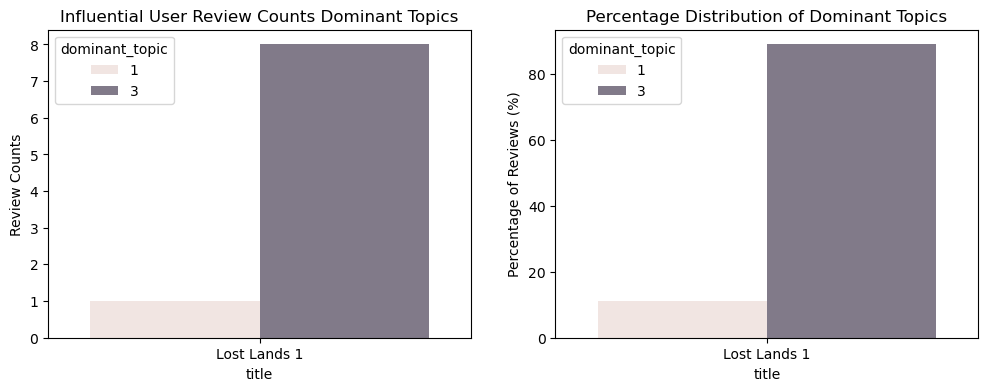

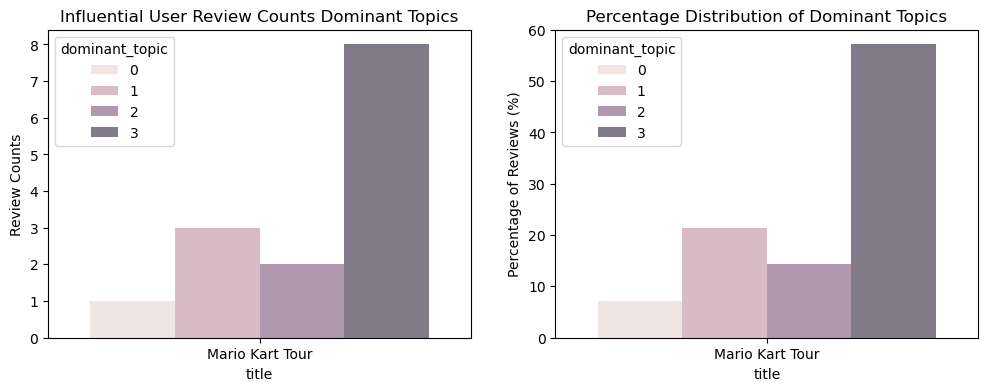

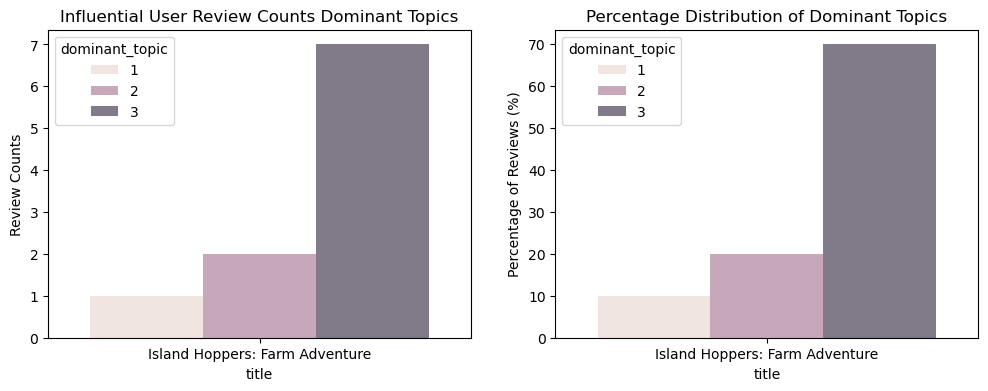

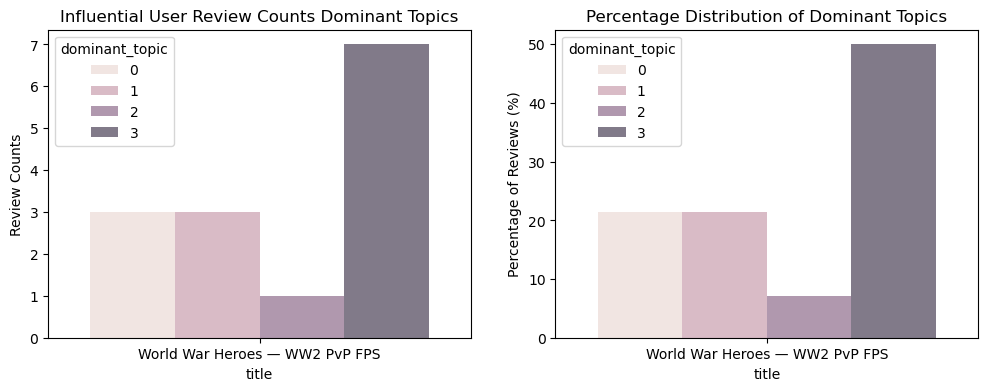

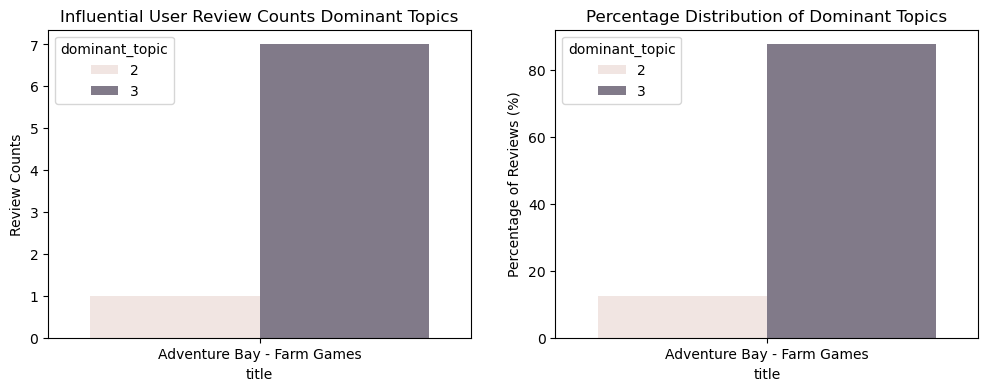

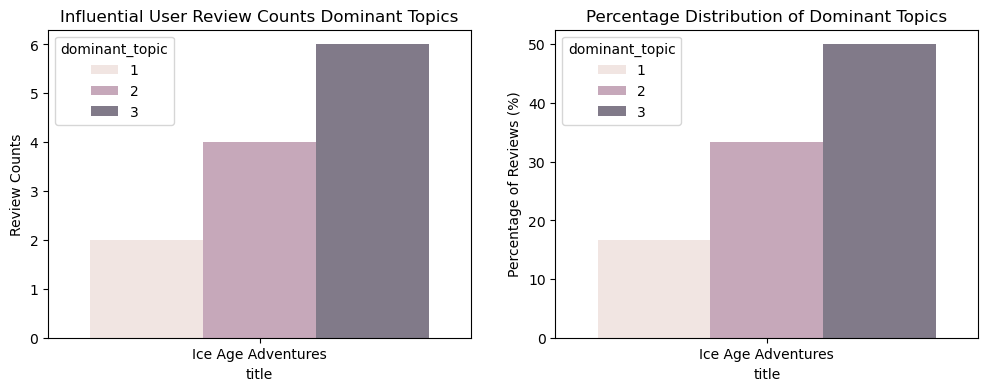

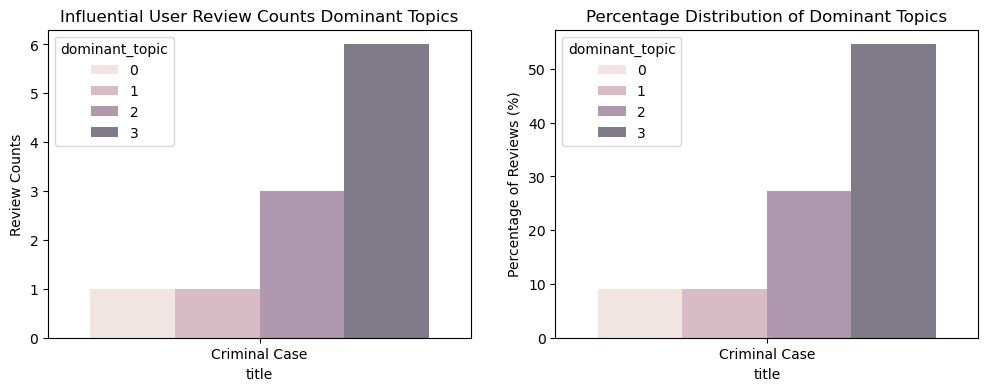

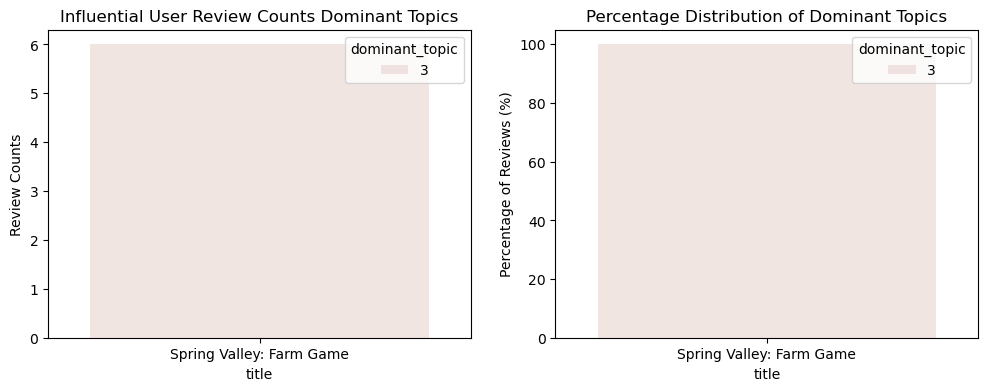

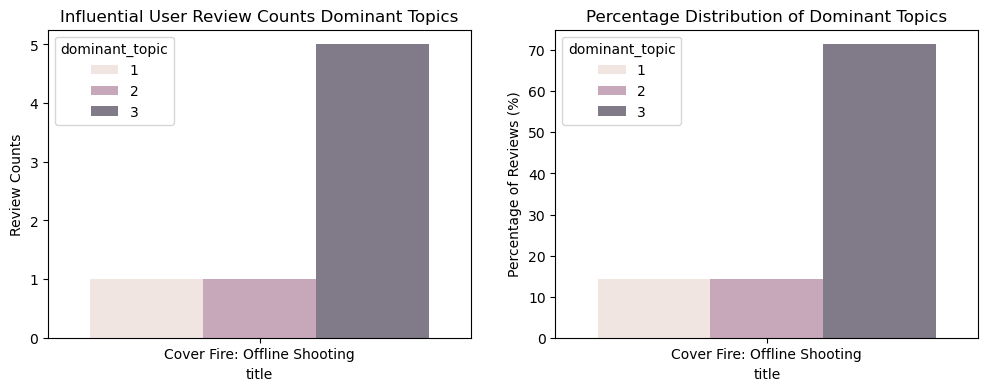

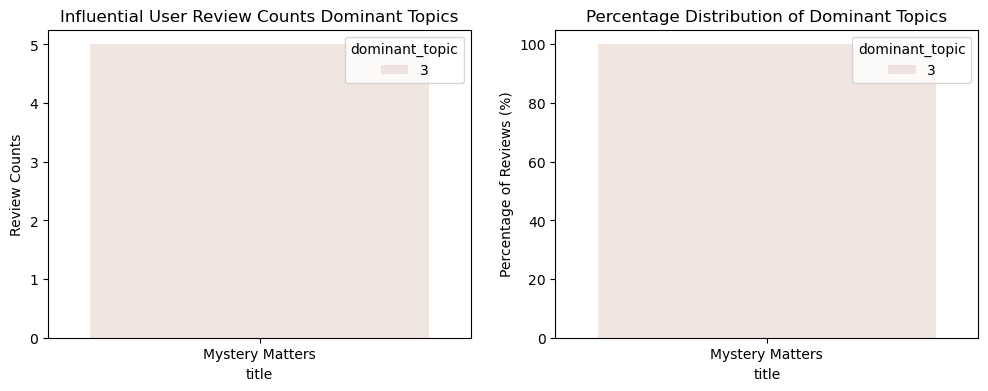

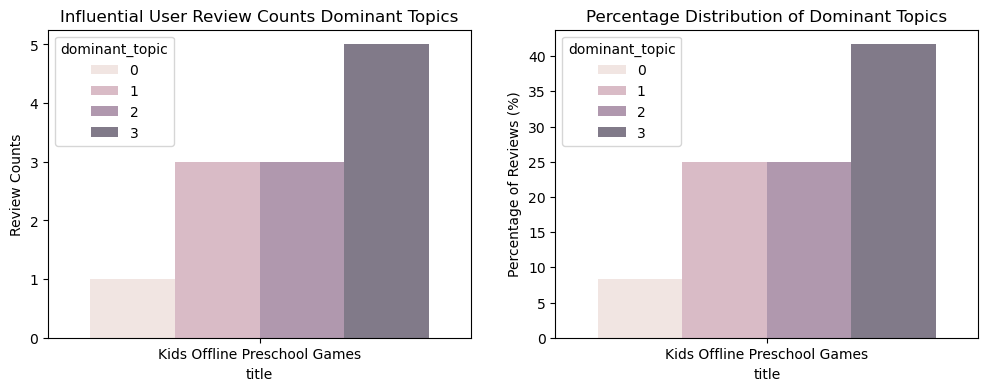

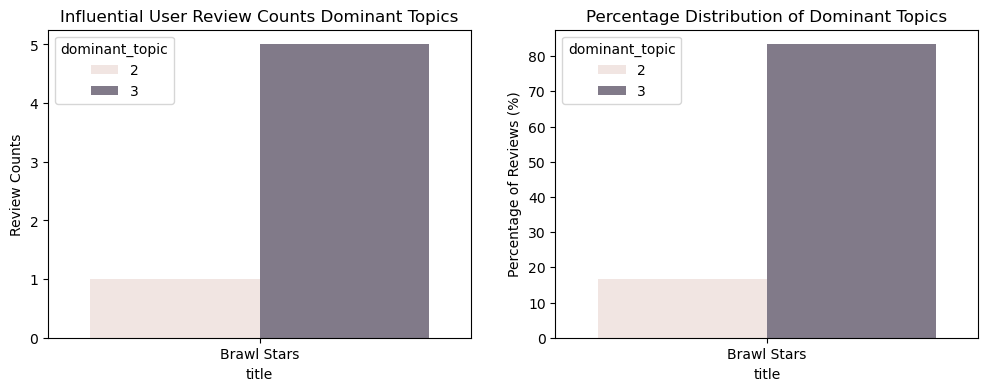

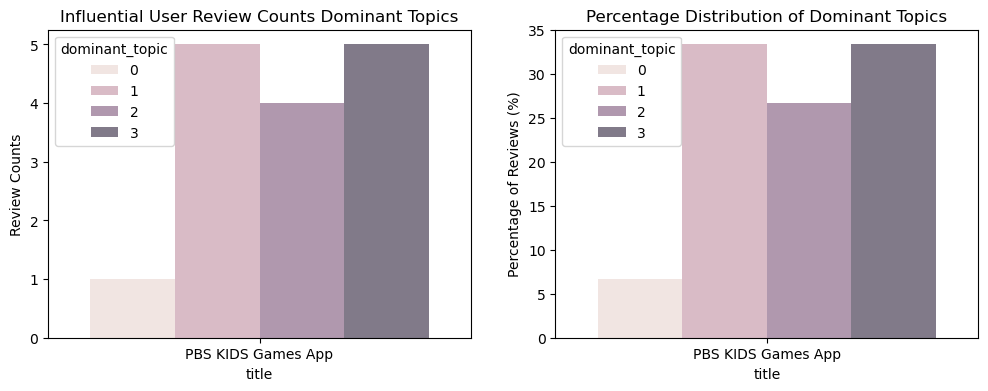

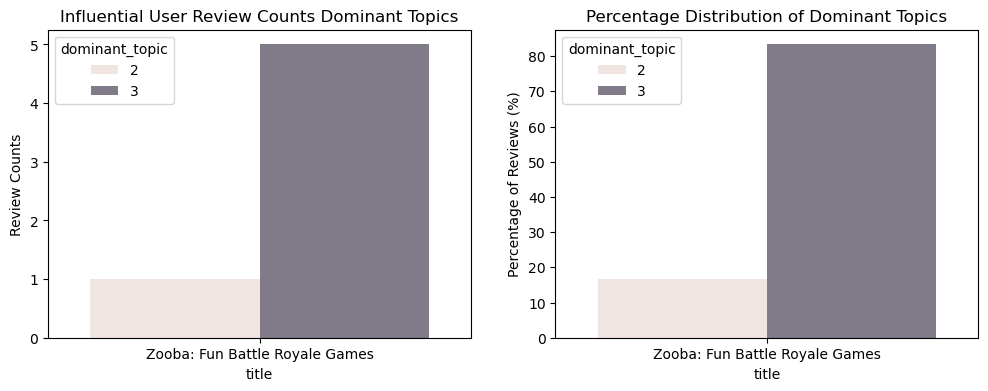

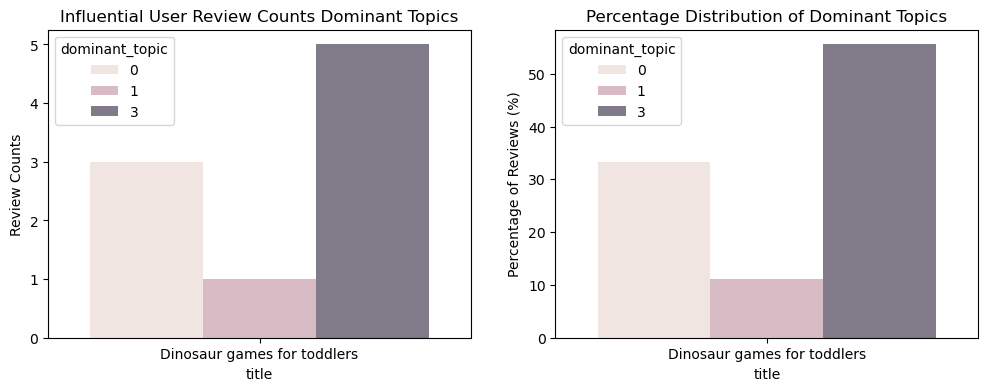

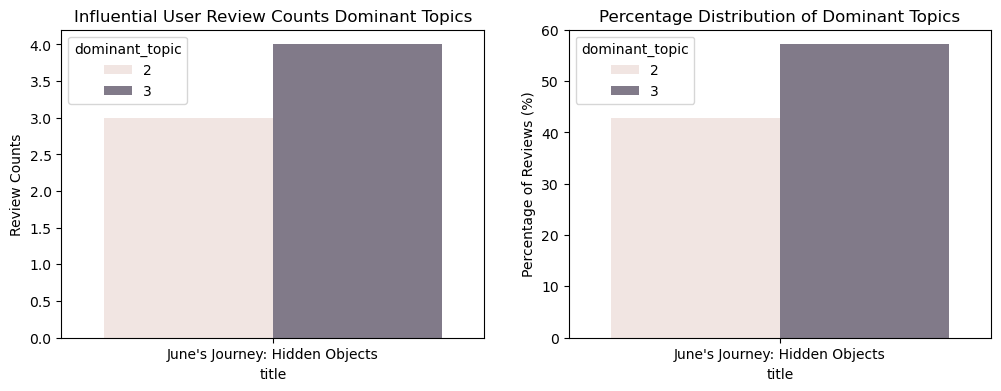

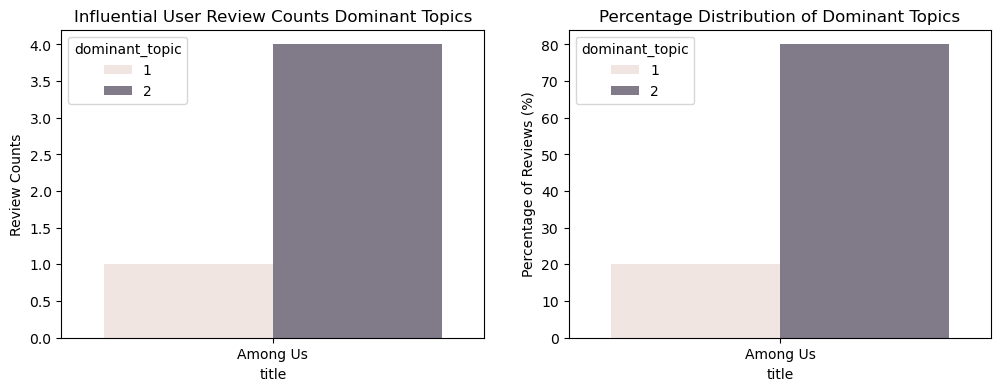

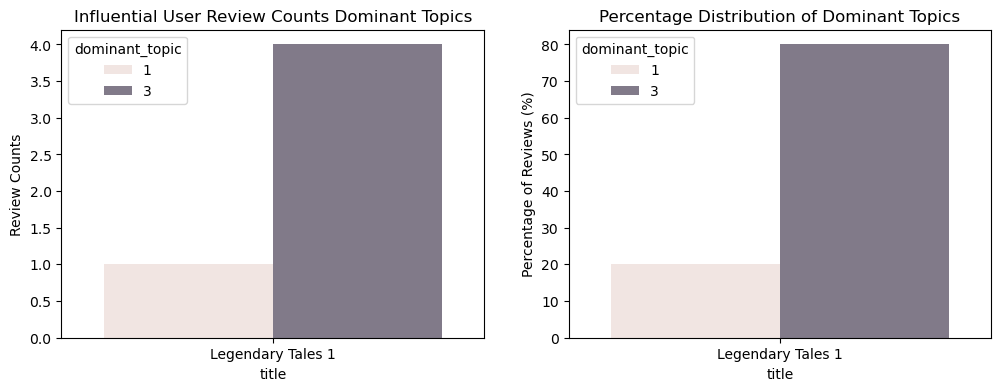

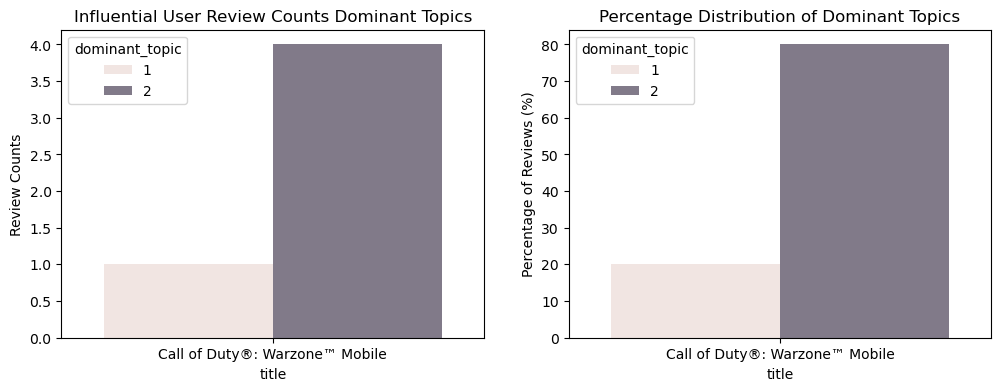

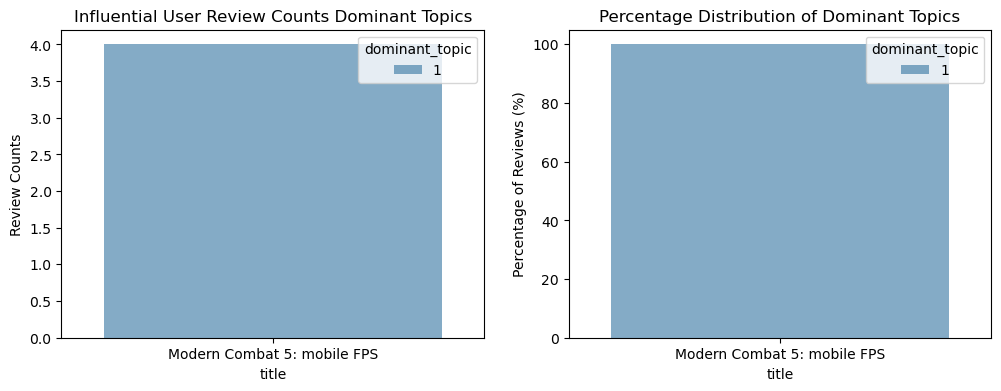

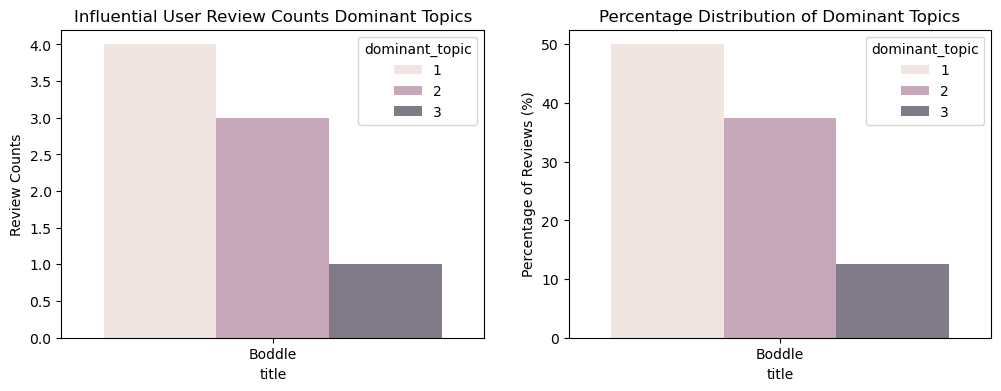

c:\Users\Mund\Anaconda3\envs\nlp_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


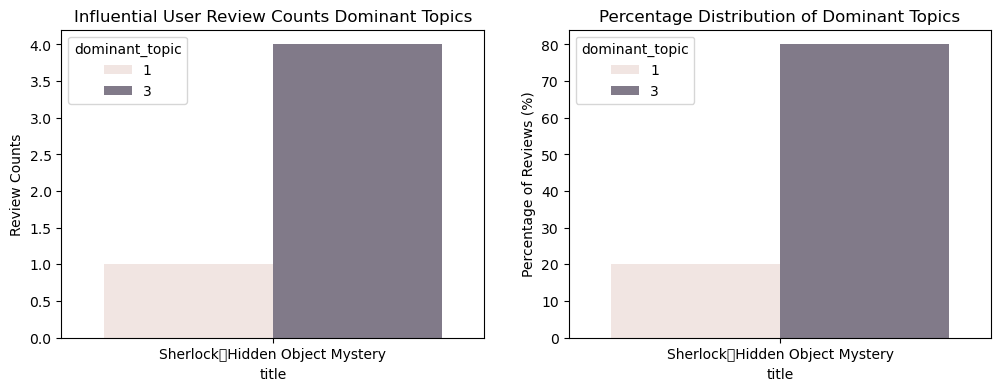

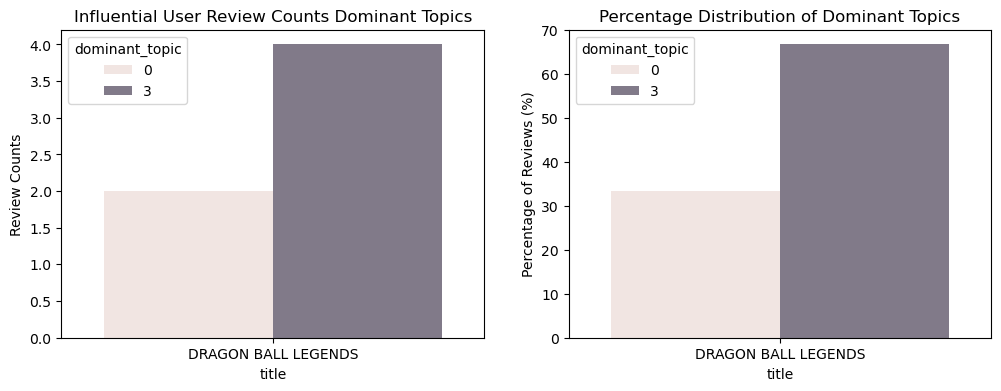

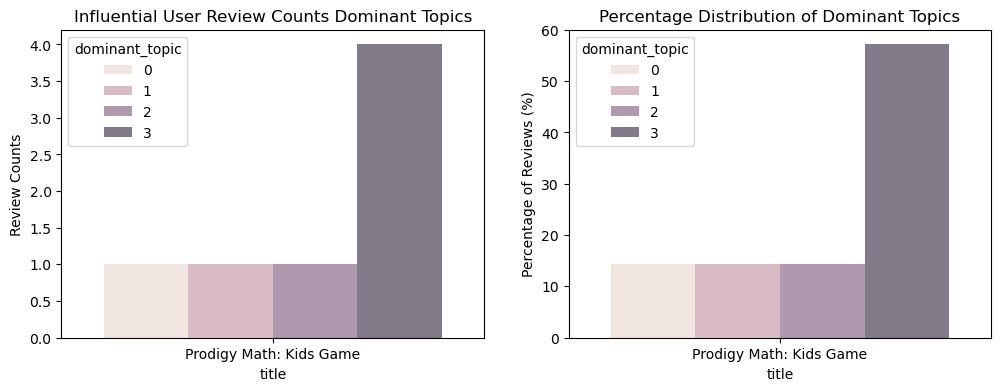

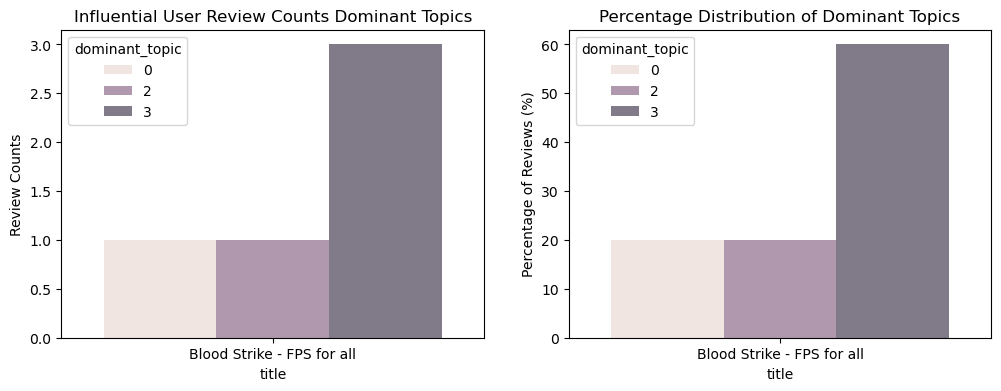

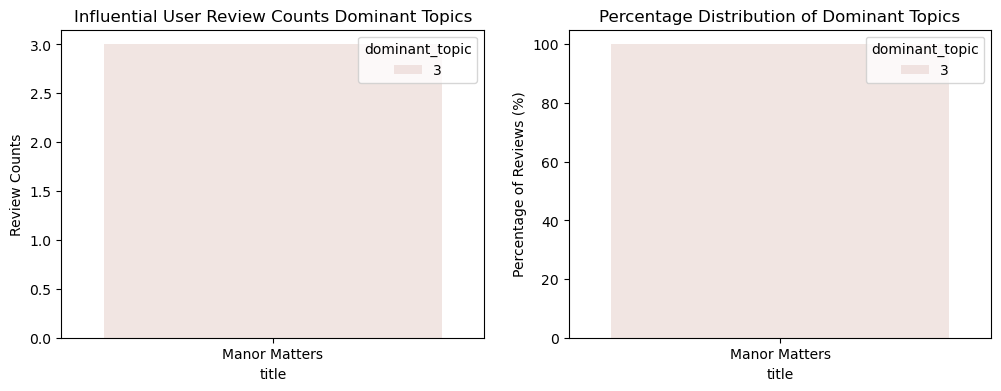

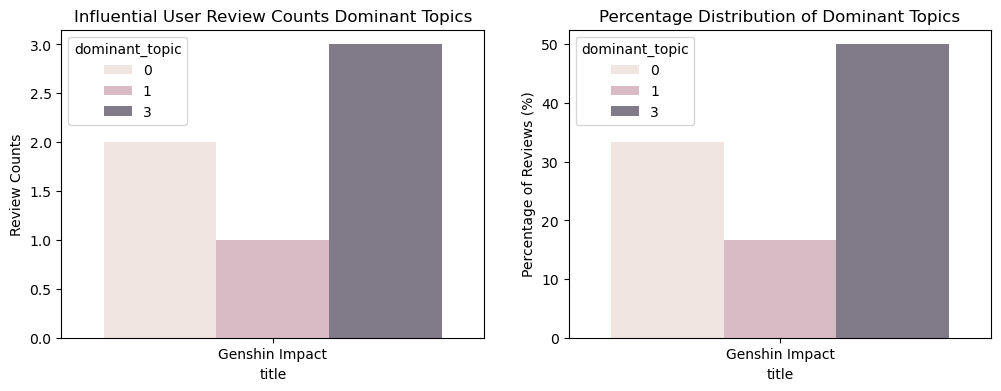

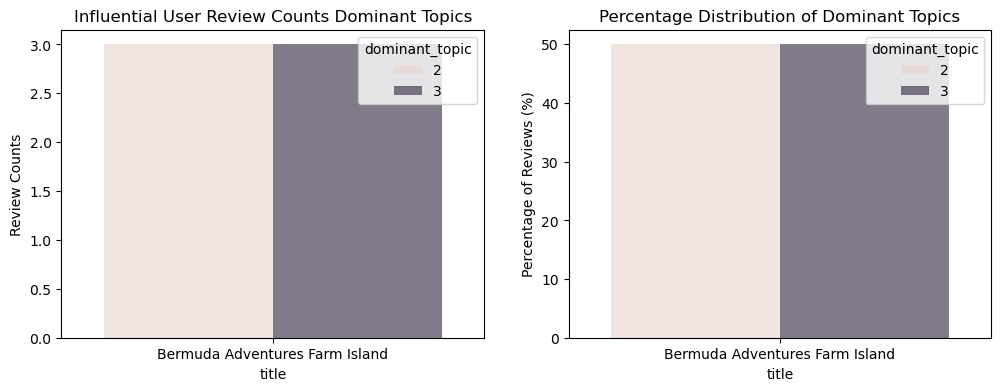

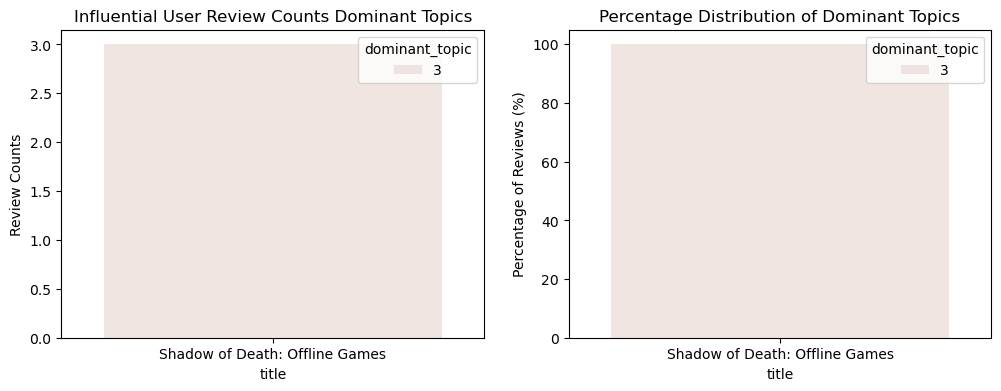

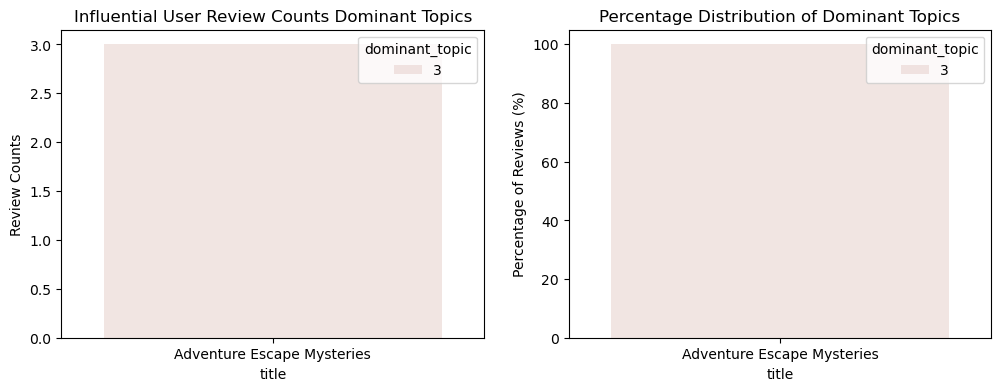

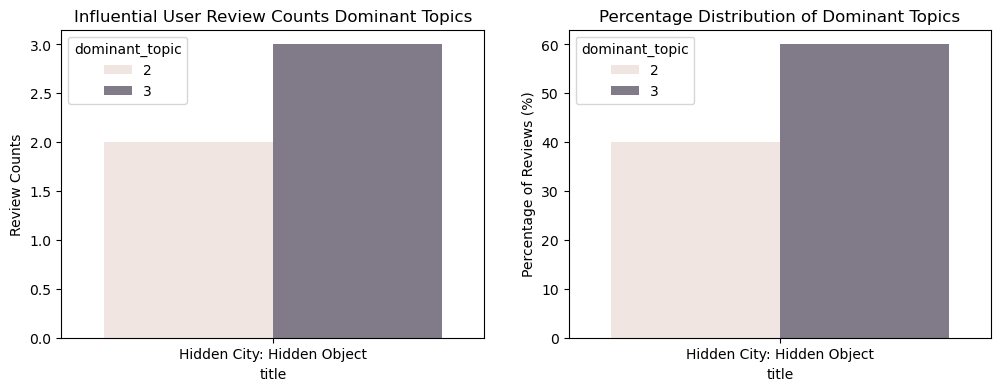

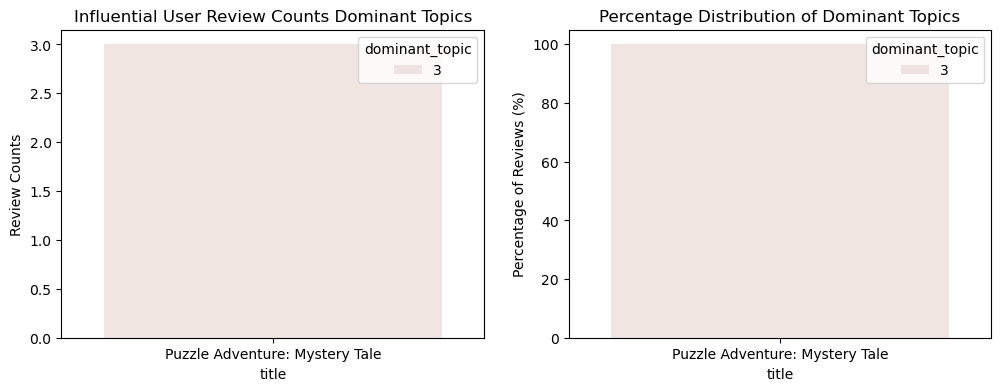

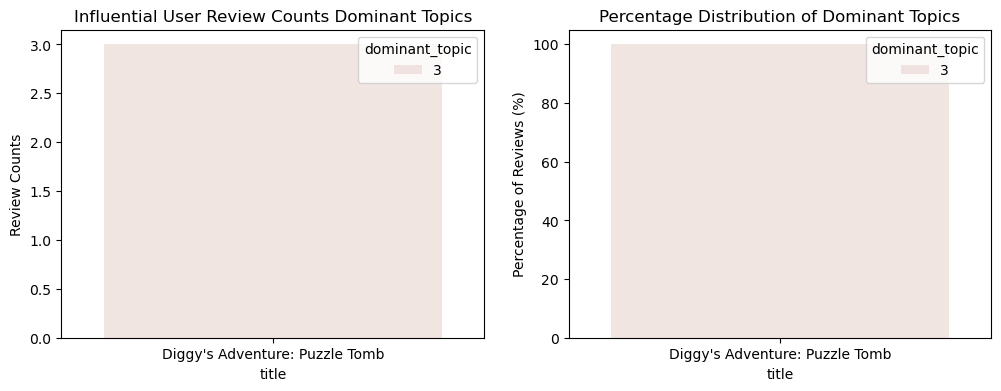

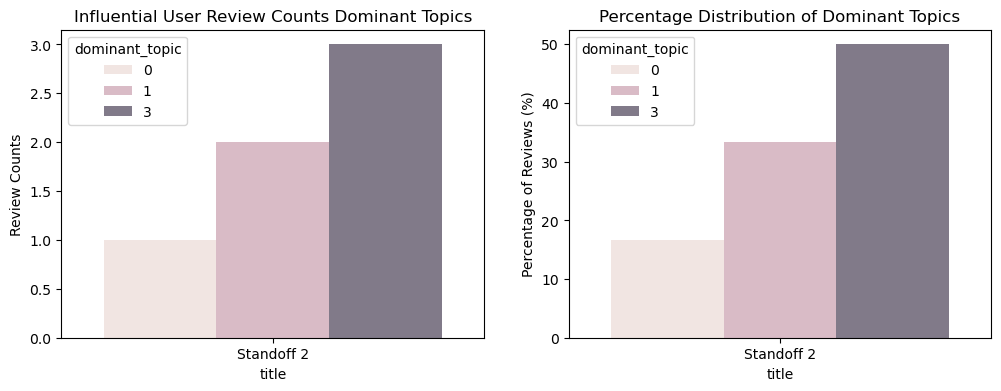

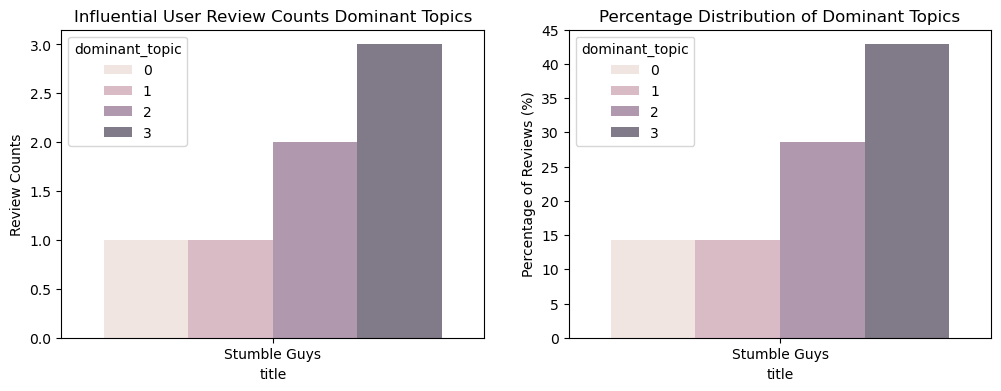

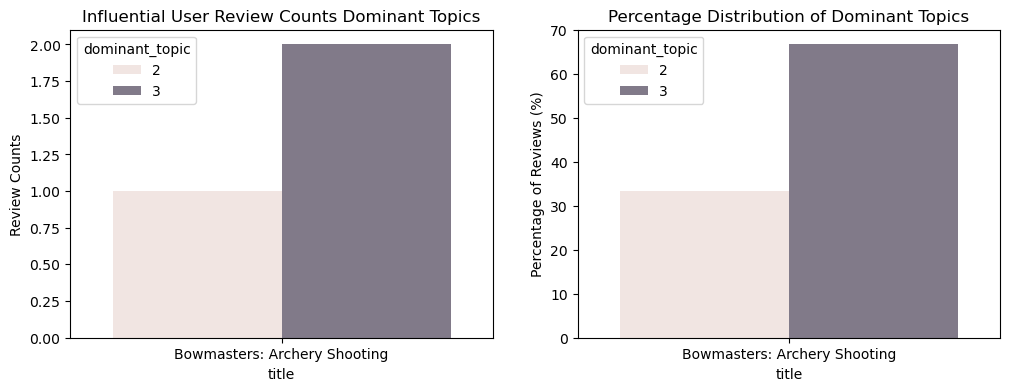

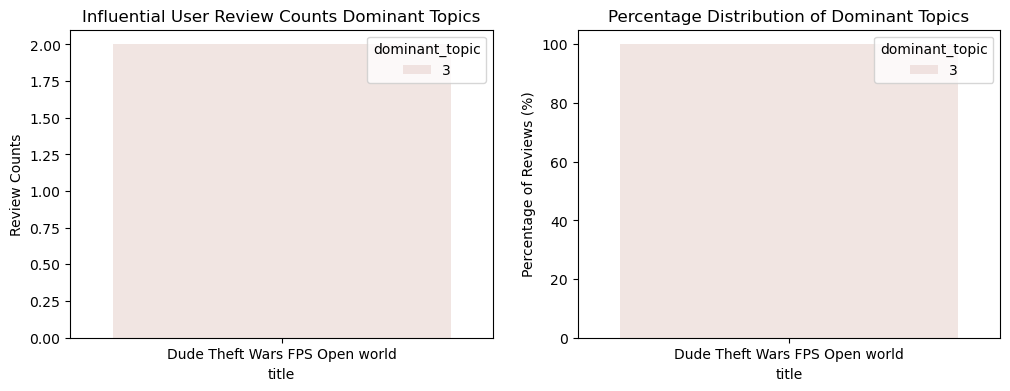

c:\Users\Mund\Anaconda3\envs\nlp_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


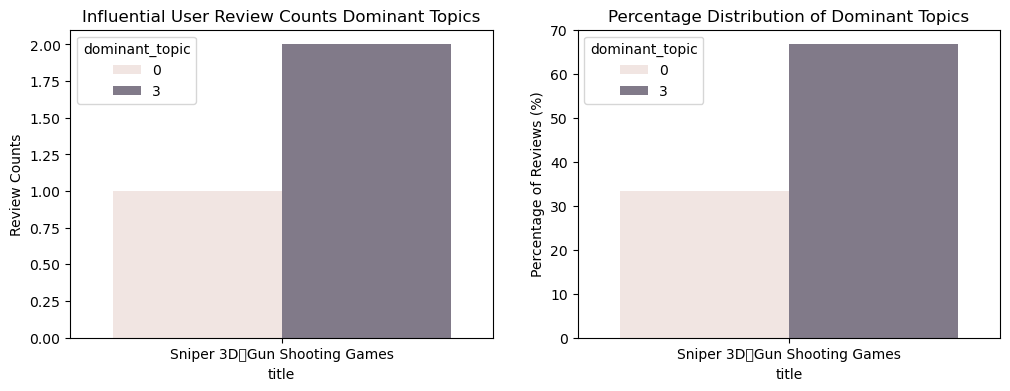

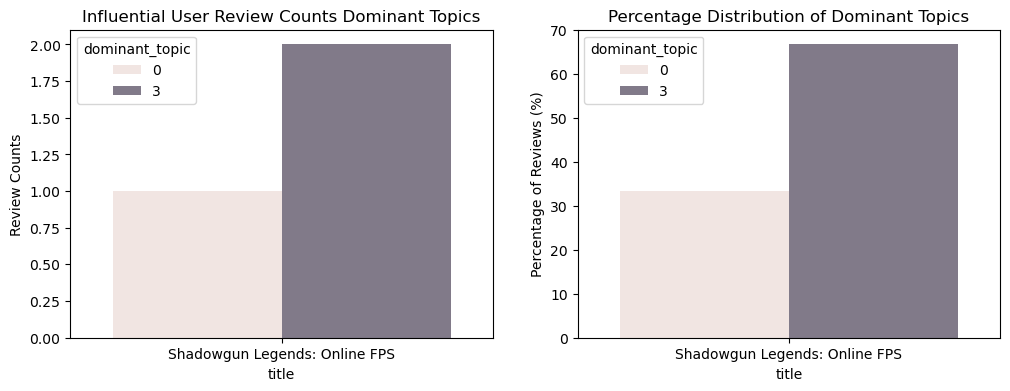

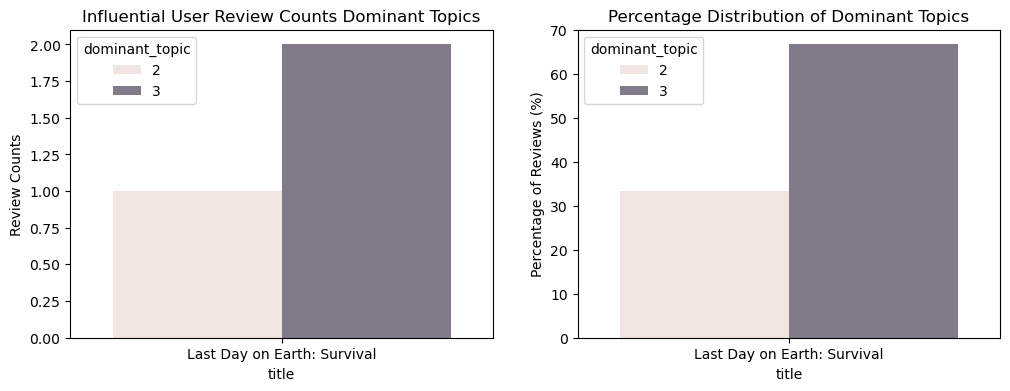

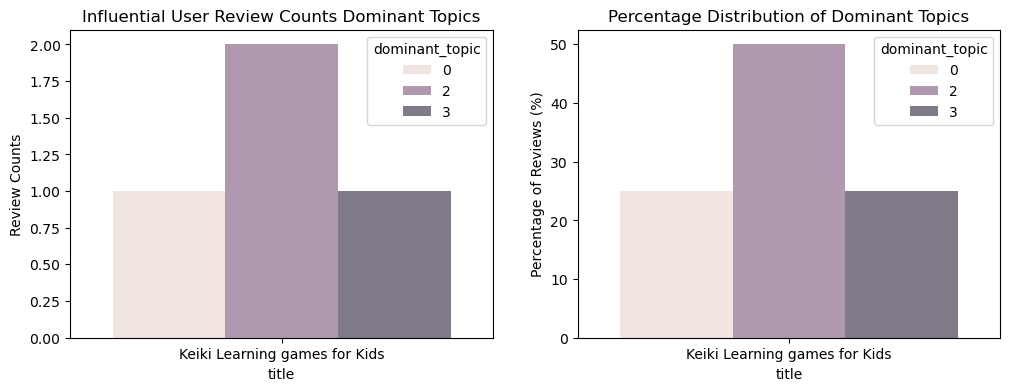

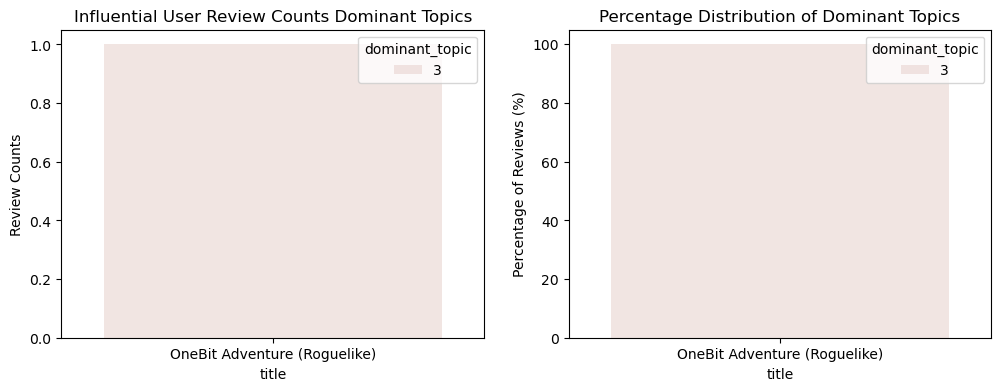

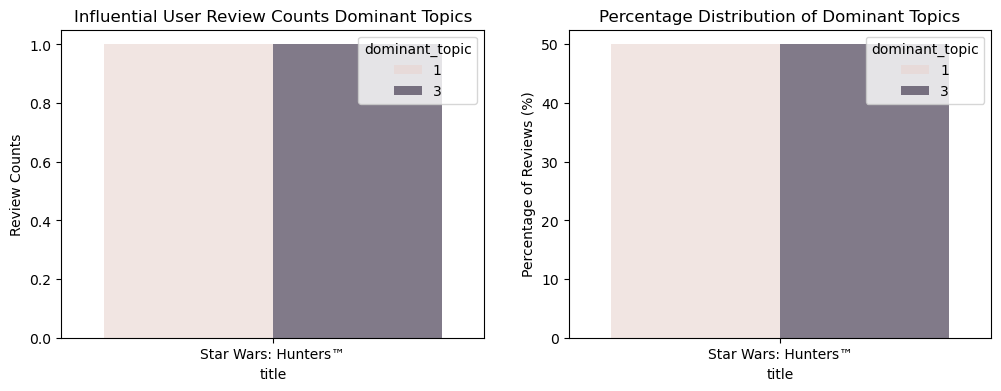

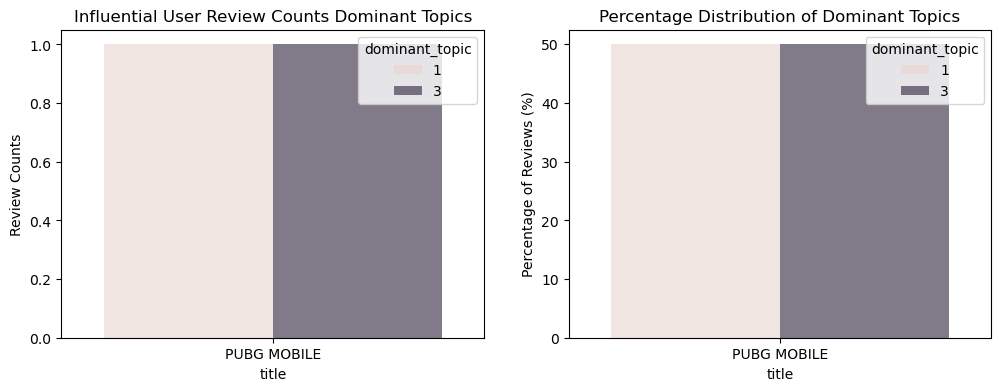

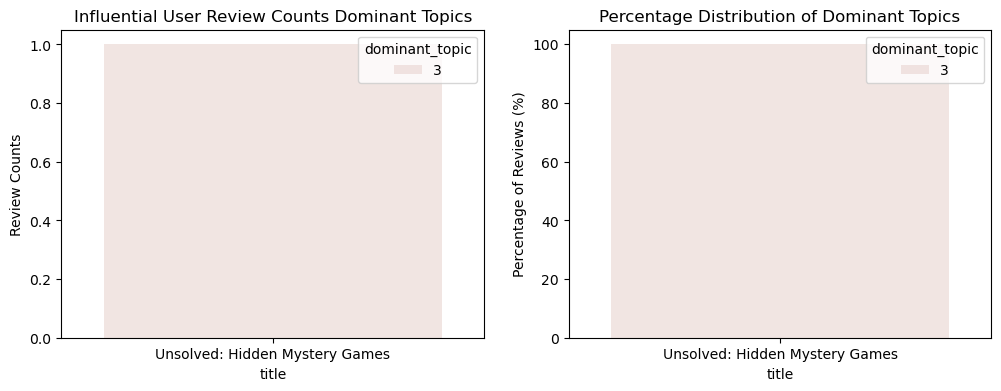

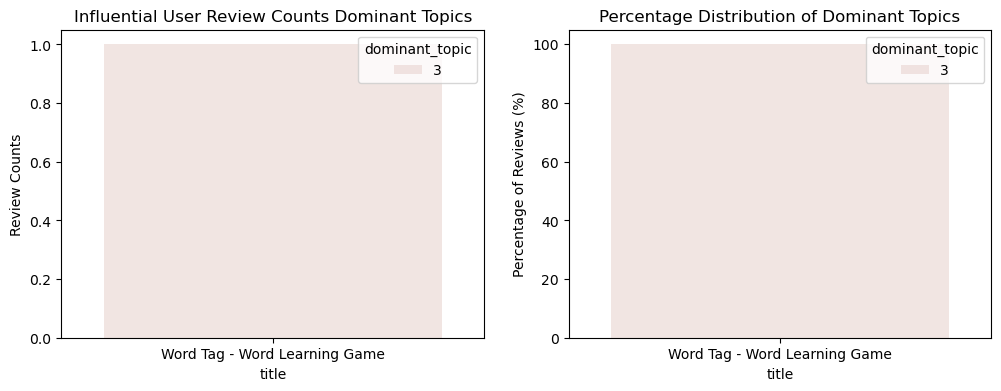

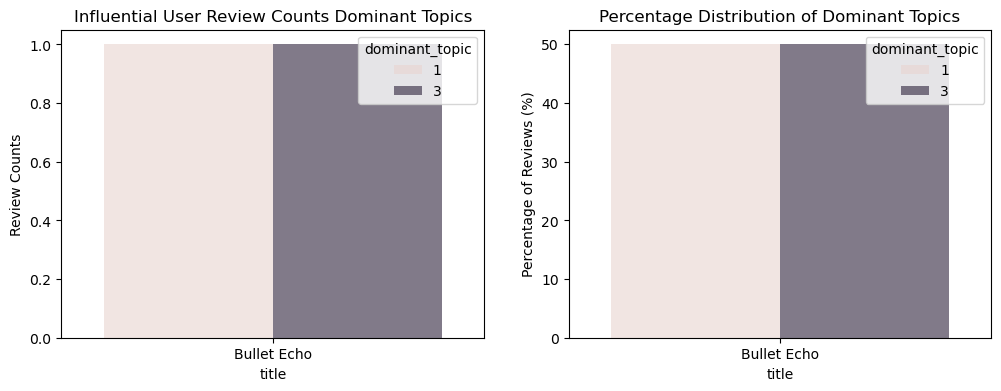

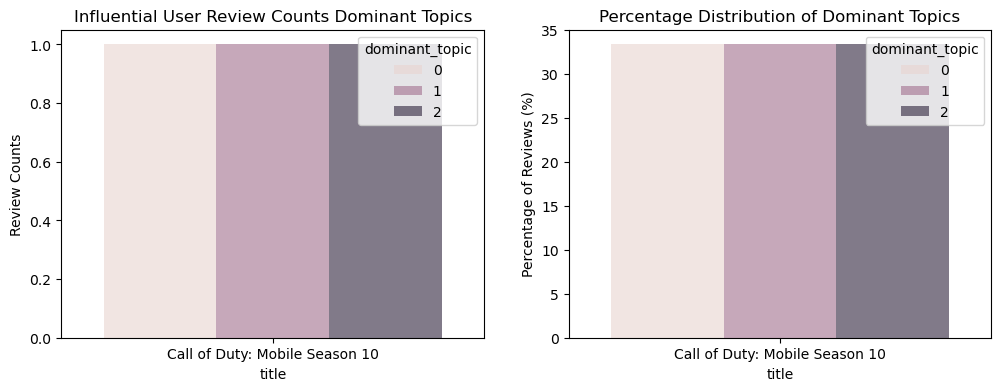

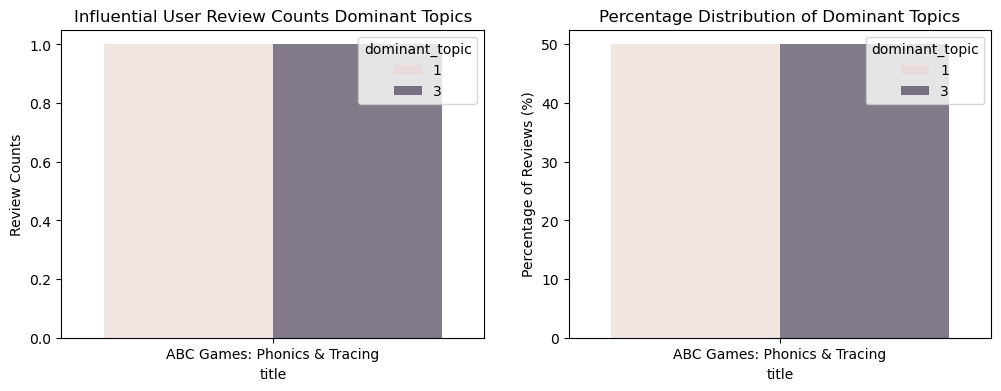

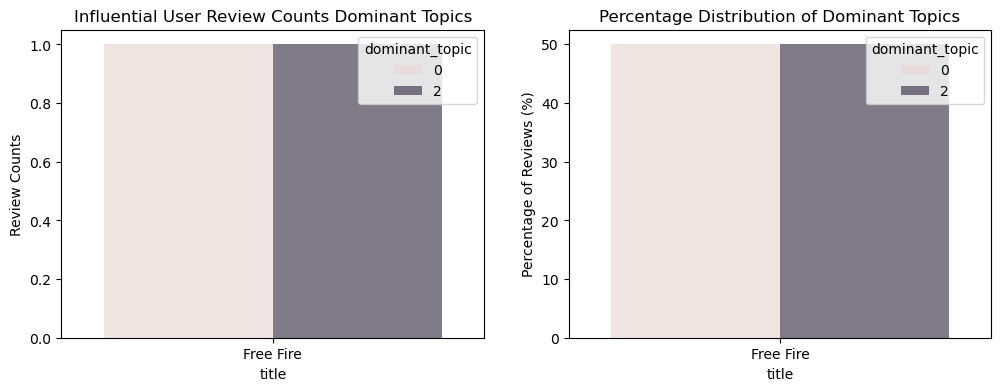

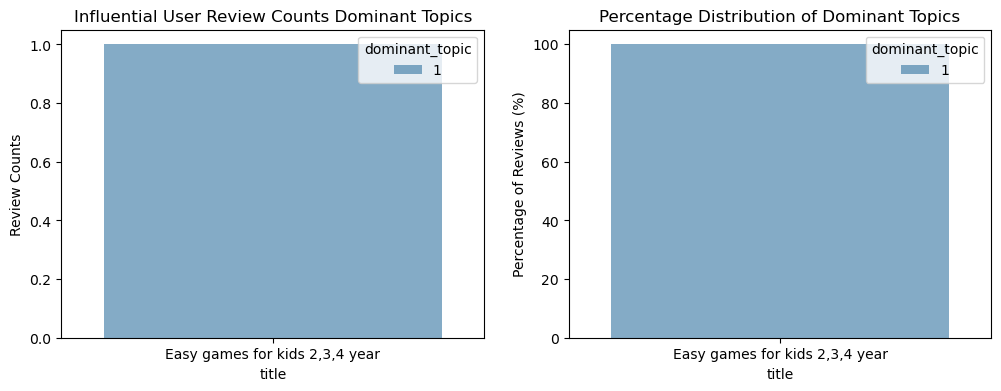

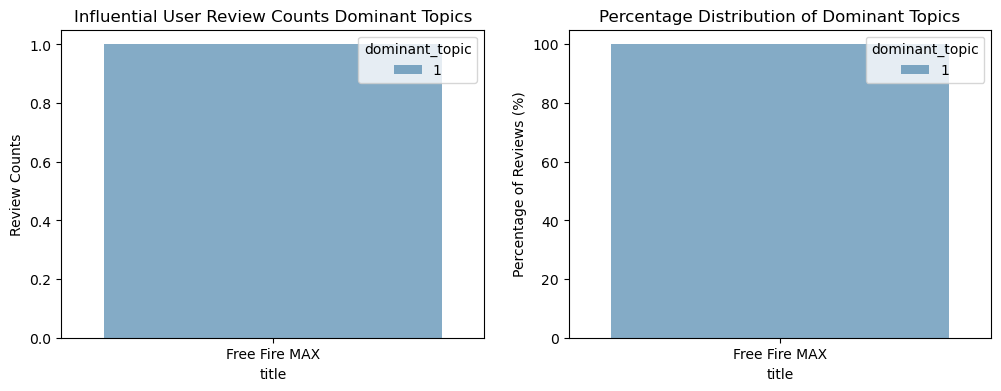

In [188]:
game_plot = final_df[['dominant_topic','title']].value_counts().reset_index()
game_plot['title_pct'] = 100*game_plot['count']/game_plot.groupby('title')['count'].transform('sum')
for game in game_plot['title'].unique():
    game_plot_filter = game_plot[game_plot['title'] == game]
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    g = sns.barplot(data = game_plot_filter,  x = 'title', y = 'count', hue = 'dominant_topic',
                    errorbar=None, alpha  = .6, ax = ax[0])
    g.set_ylabel('Review Counts')
    g.set_title(f'Influential User Review Counts Dominant Topics')
    g = sns.barplot(data = game_plot_filter,  x = 'title', y = 'title_pct', hue = 'dominant_topic',
                    errorbar=None, alpha  = .6, ax = ax[1])
    g.set_ylabel('Percentage of Reviews (%)')
    g.set_title(f'Percentage Distribution of Dominant Topics')
    plt.show()


#### Topics Distribution Per Developer

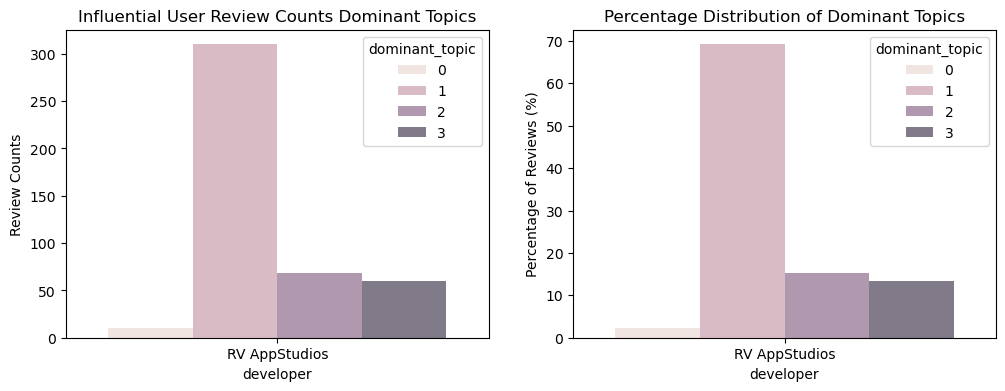

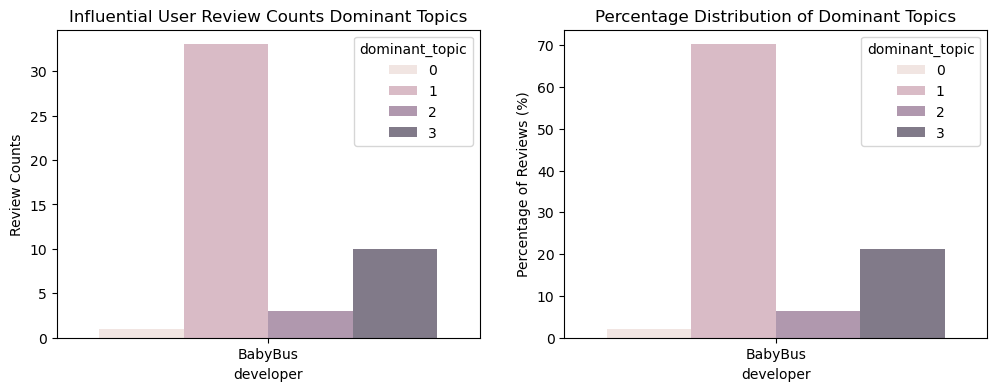

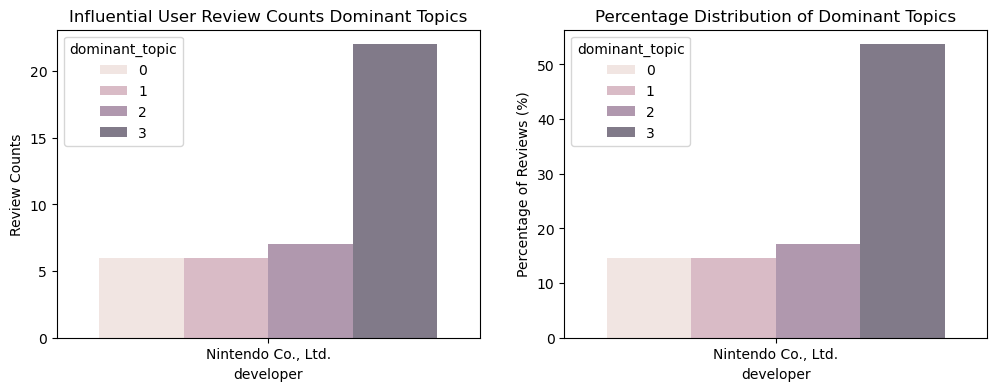

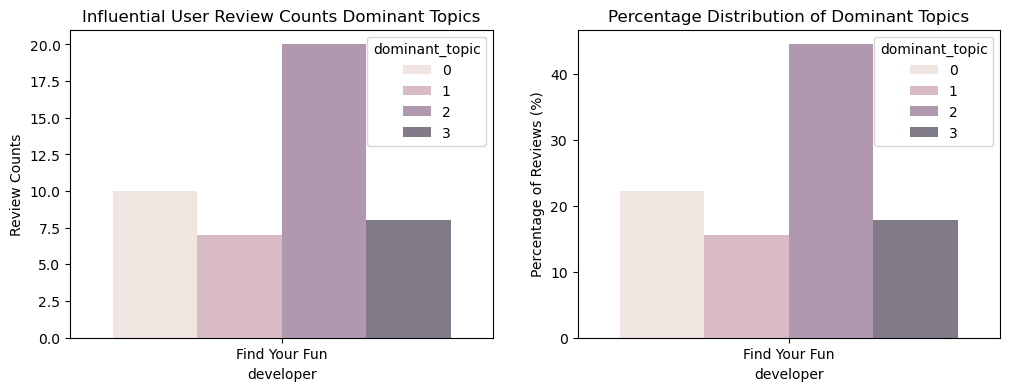

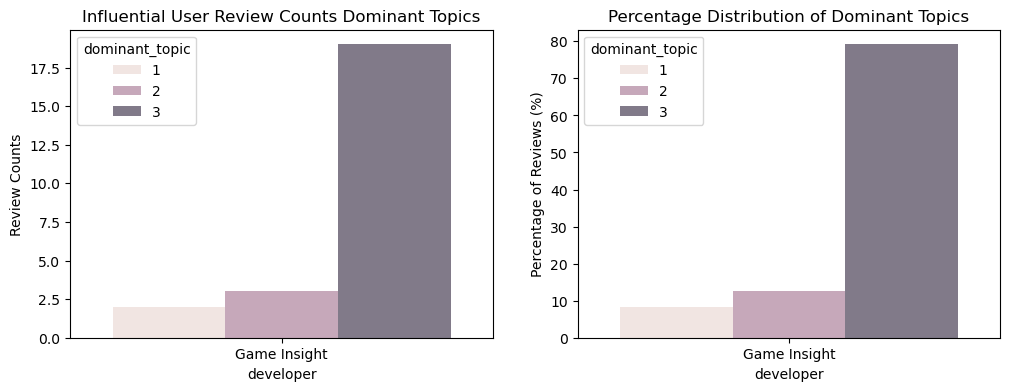

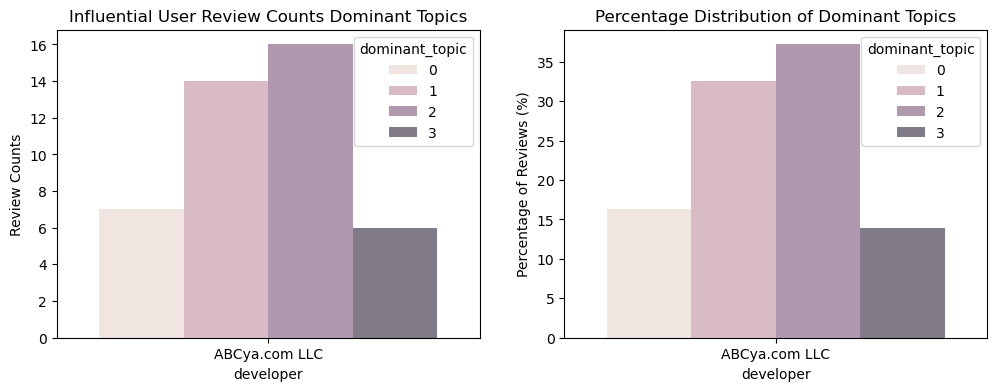

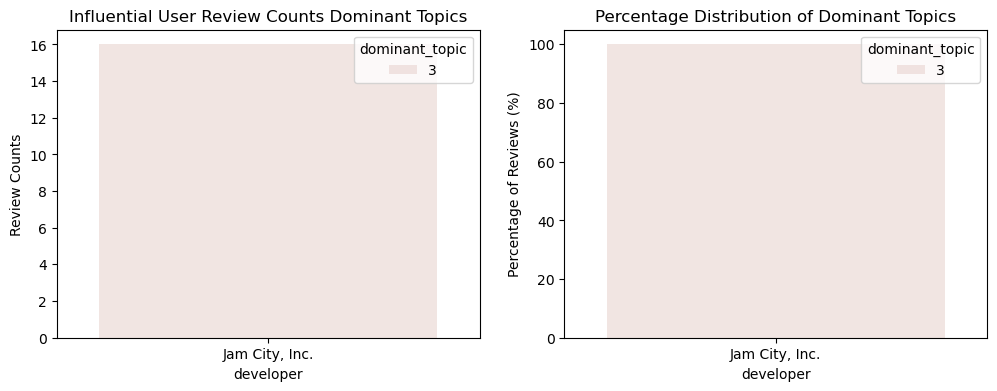

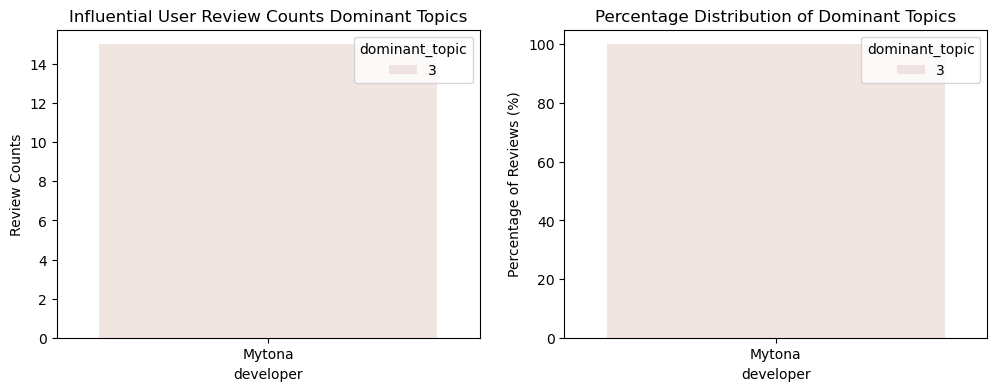

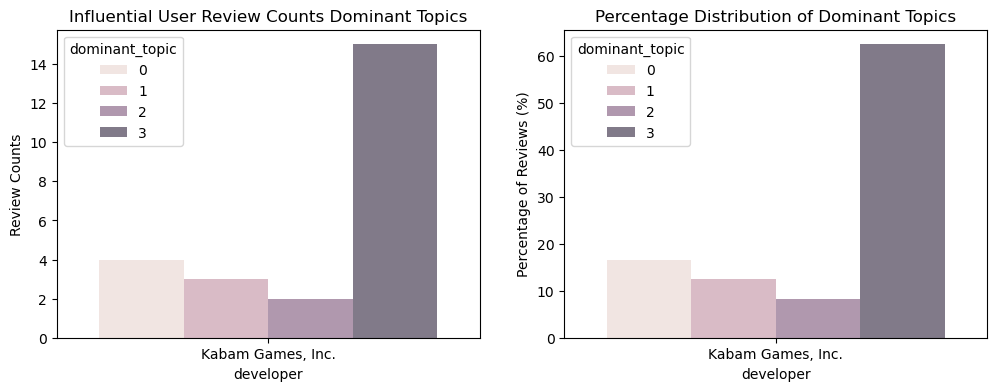

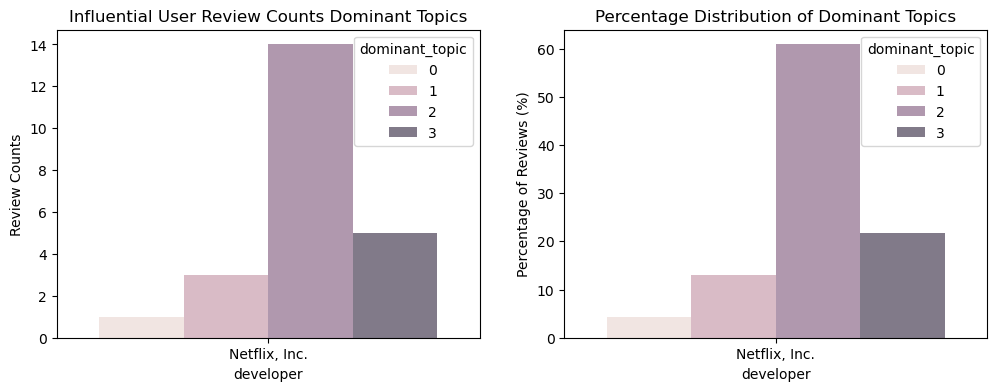

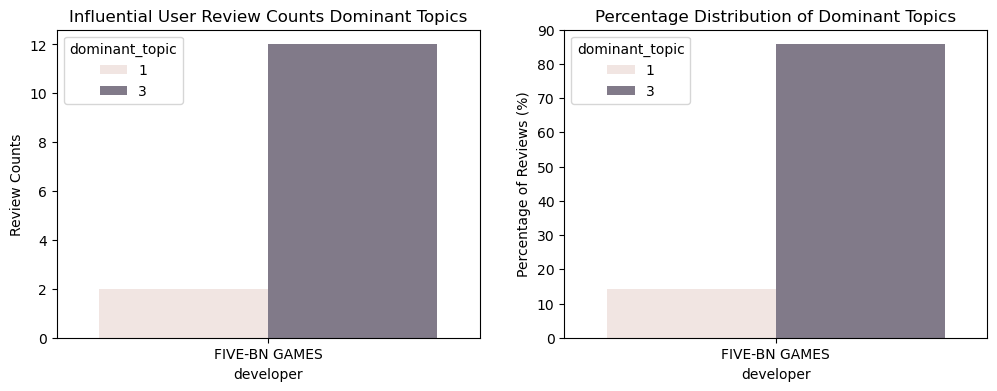

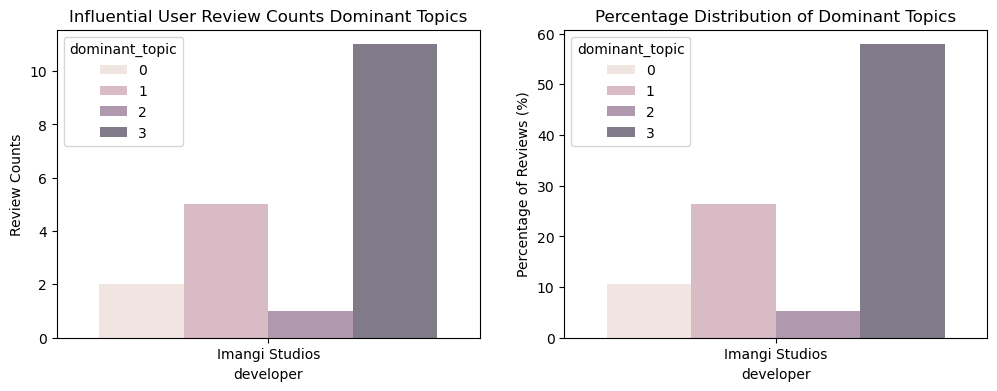

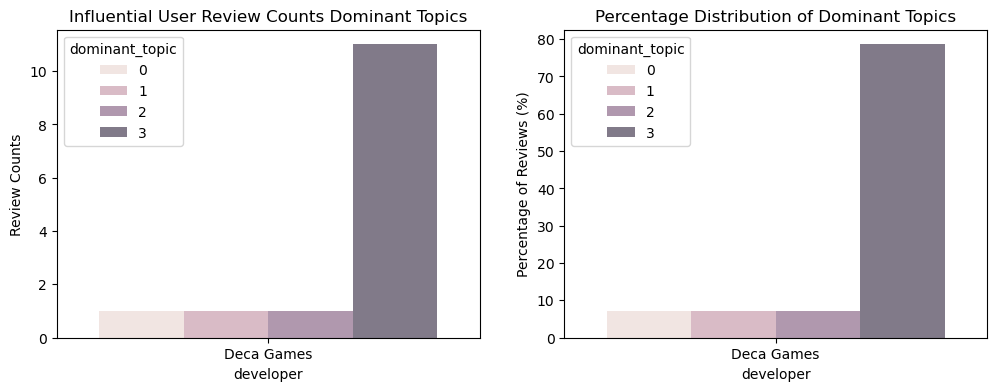

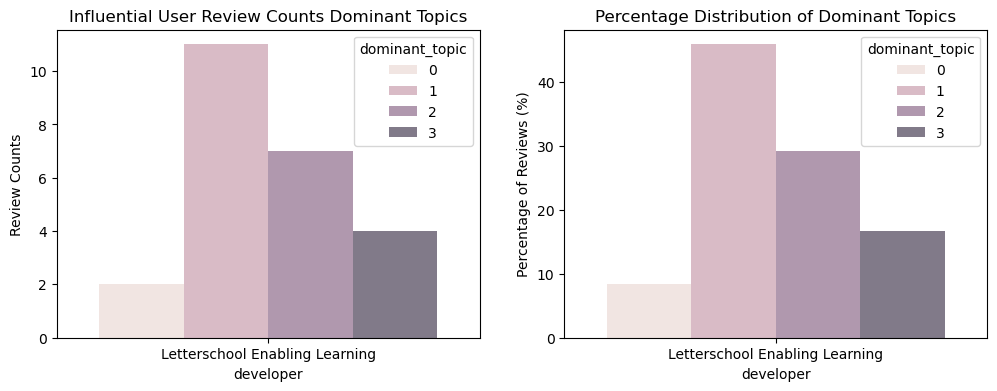

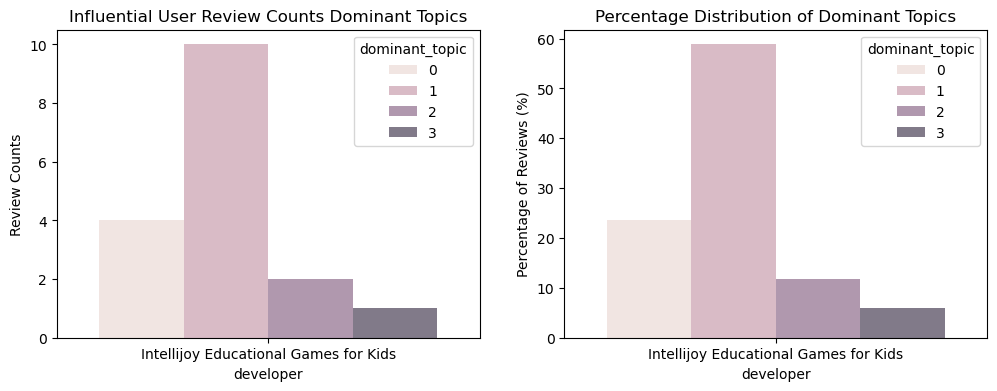

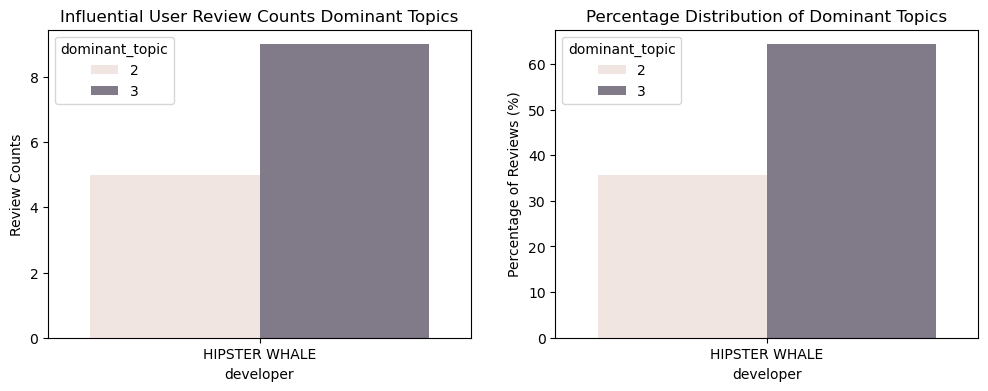

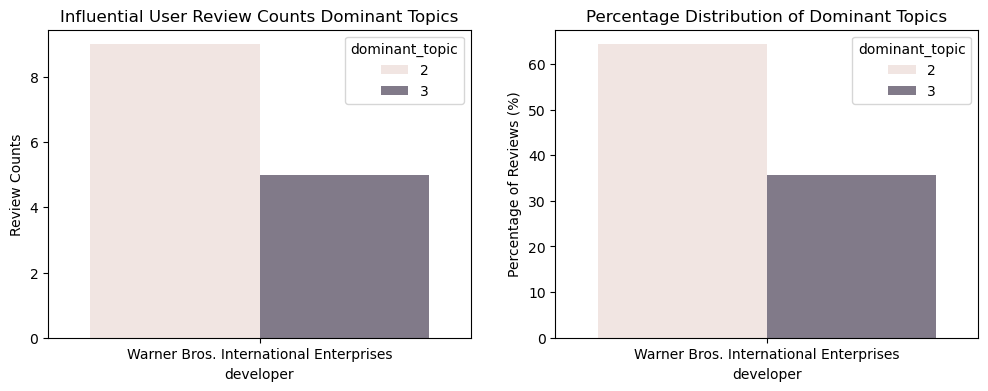

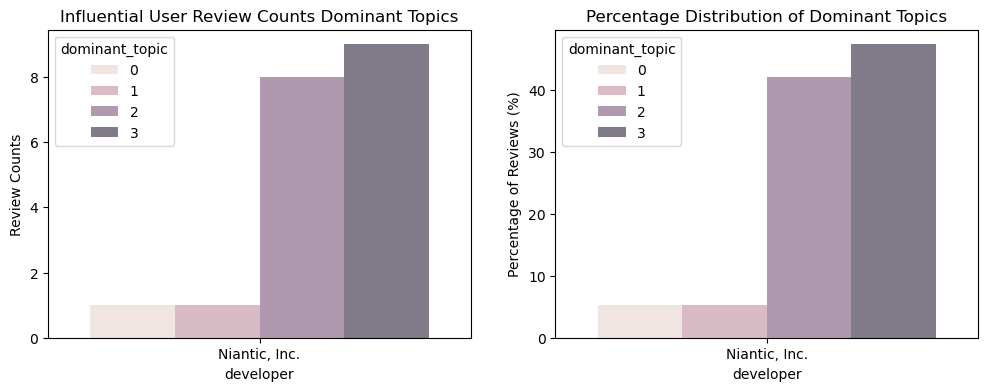

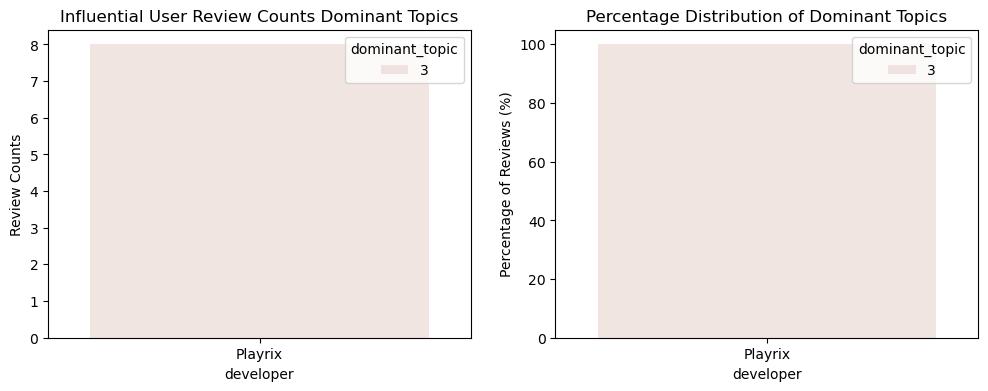

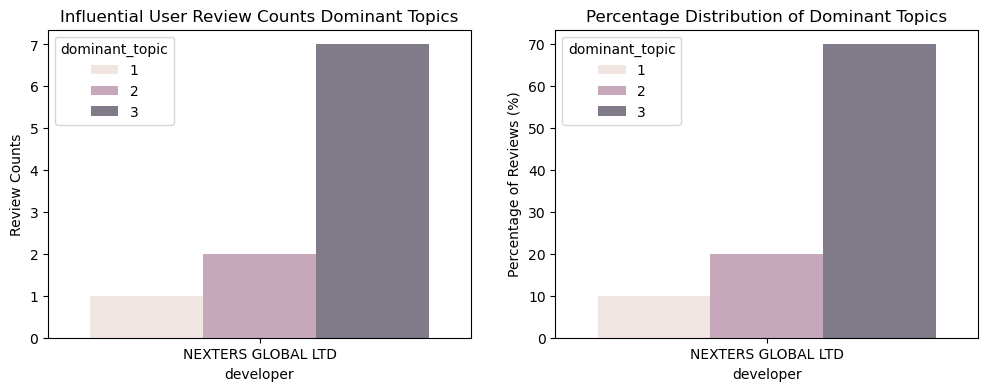

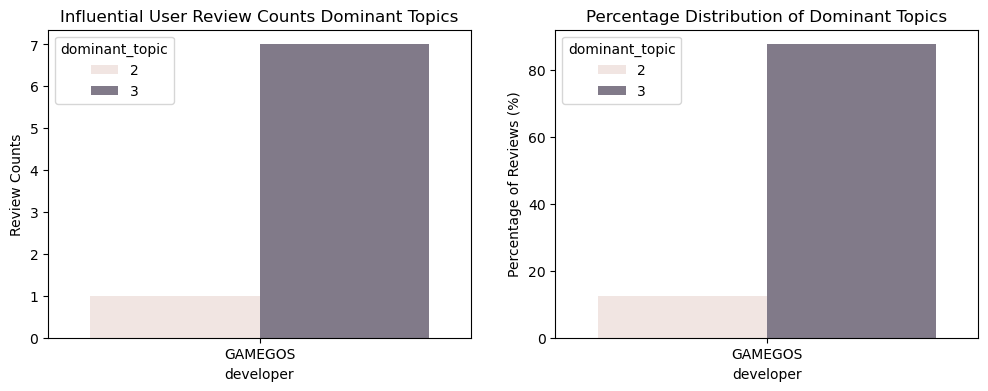

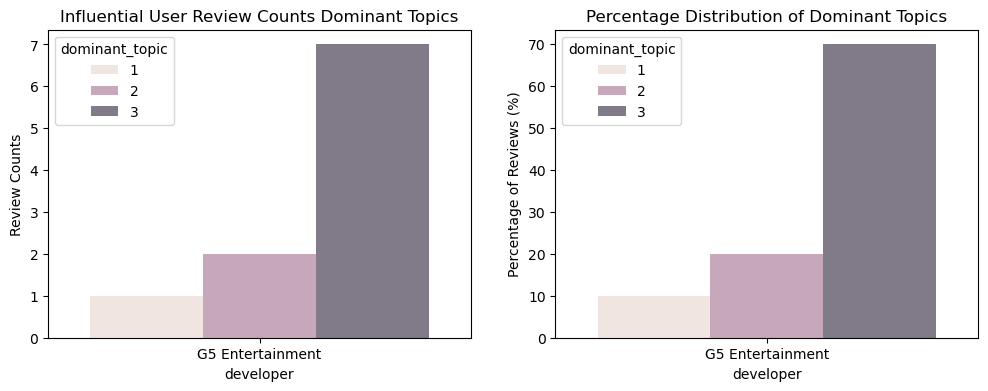

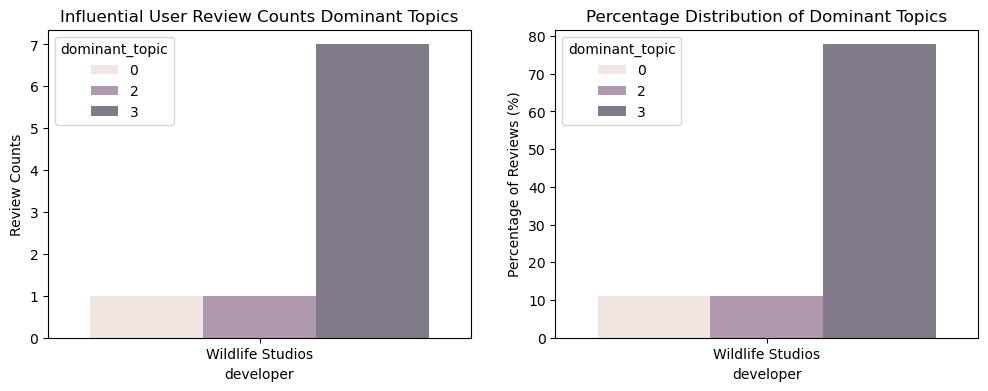

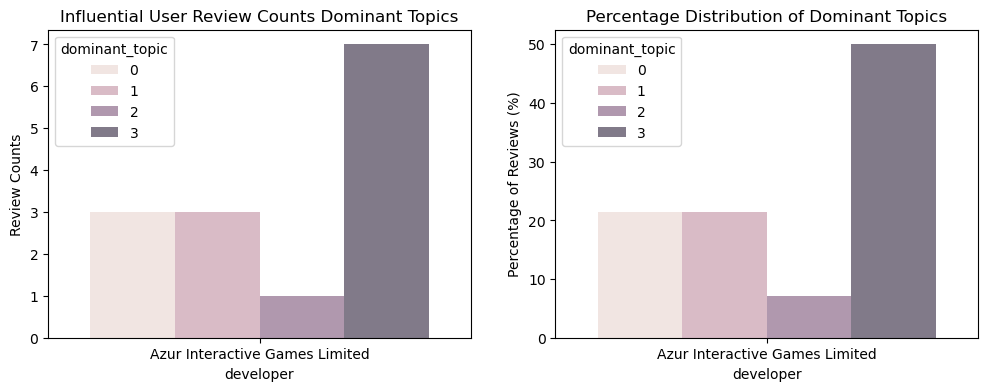

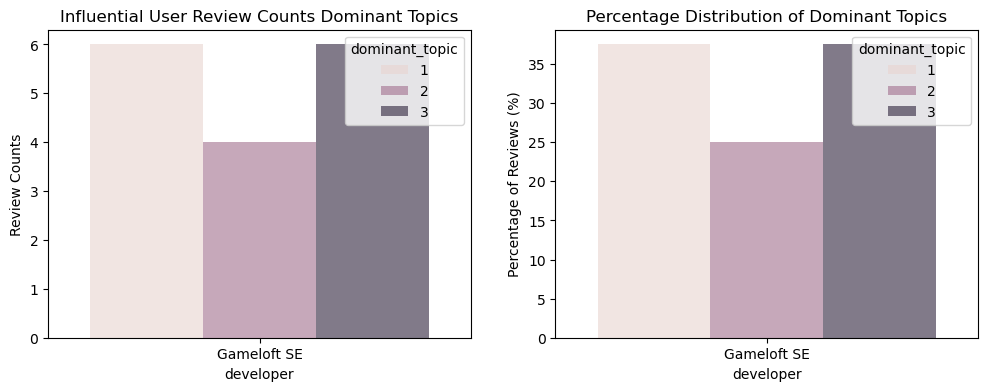

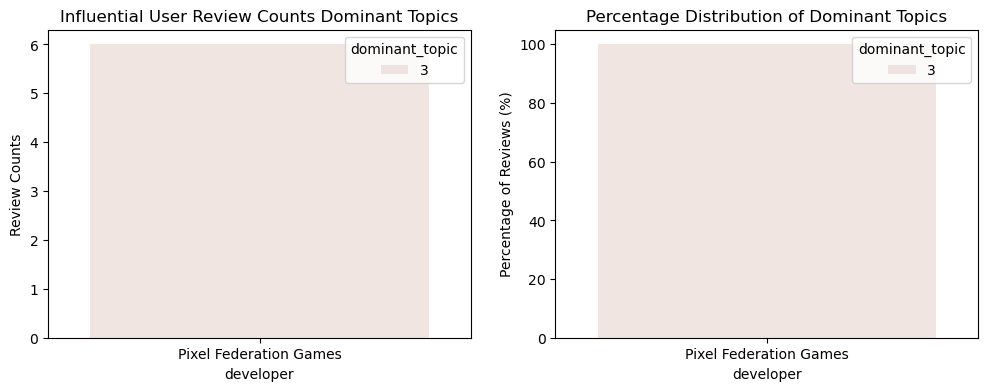

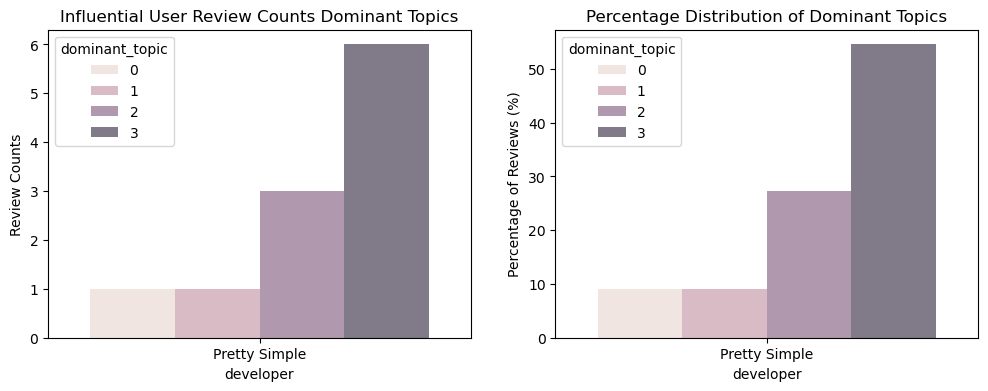

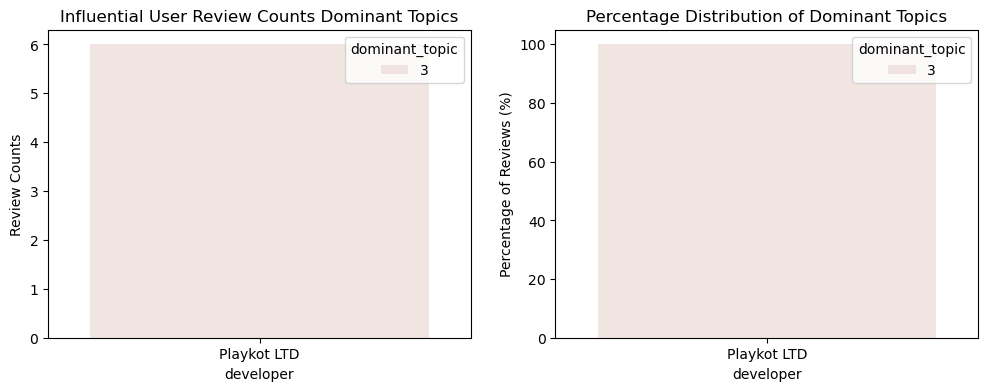

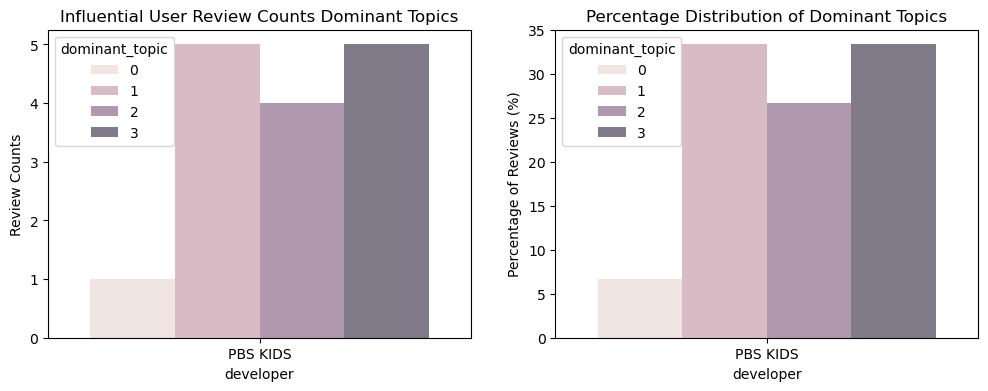

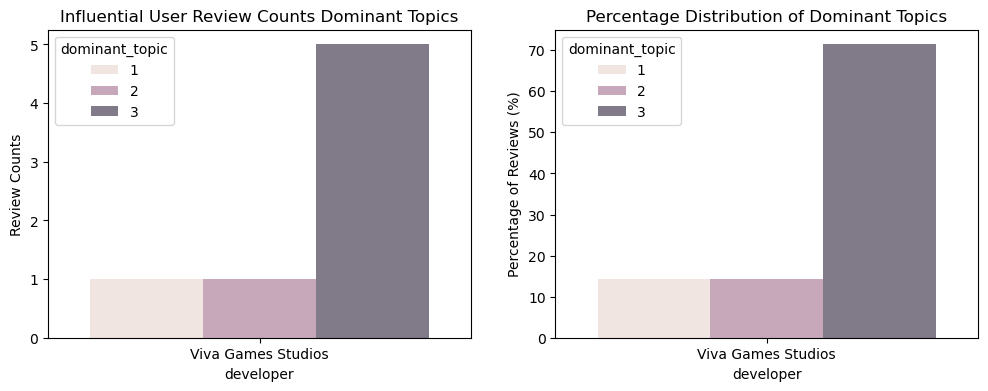

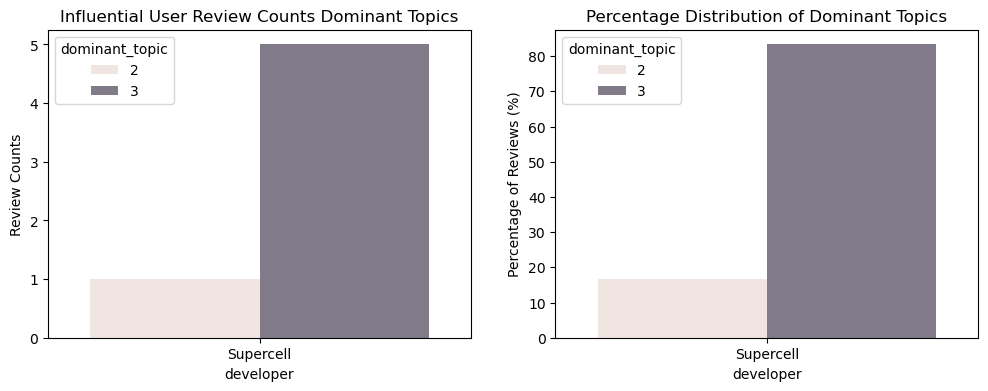

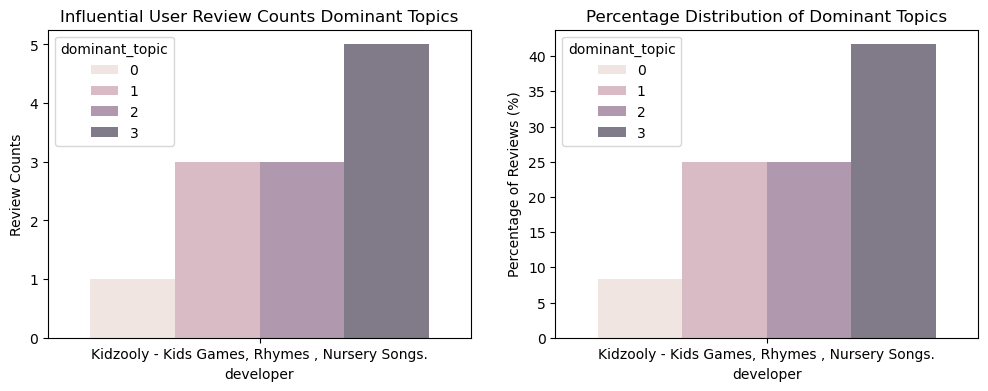

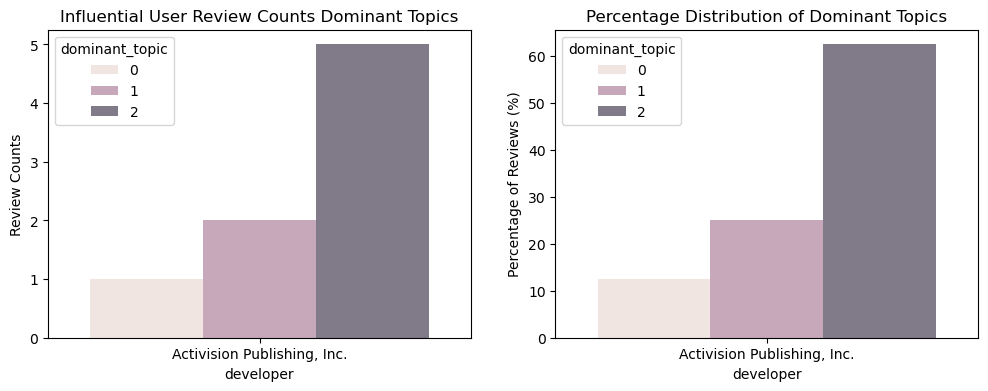

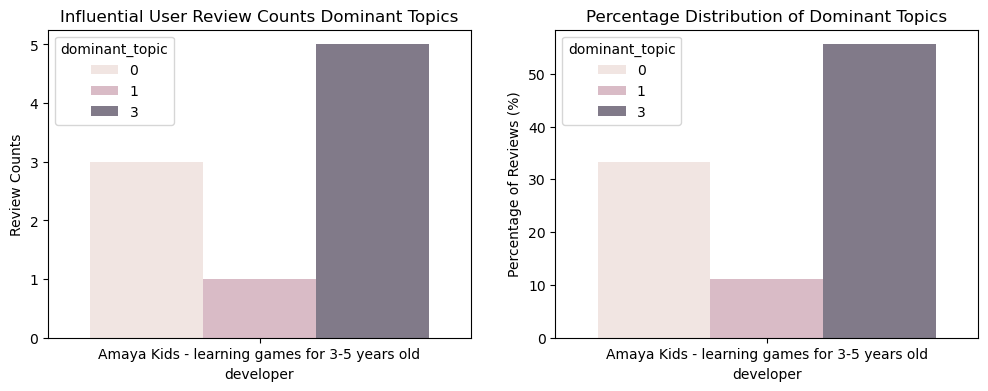

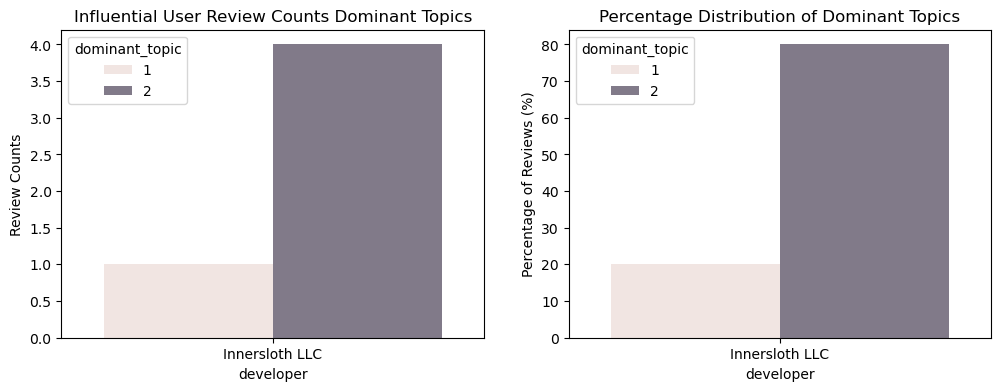

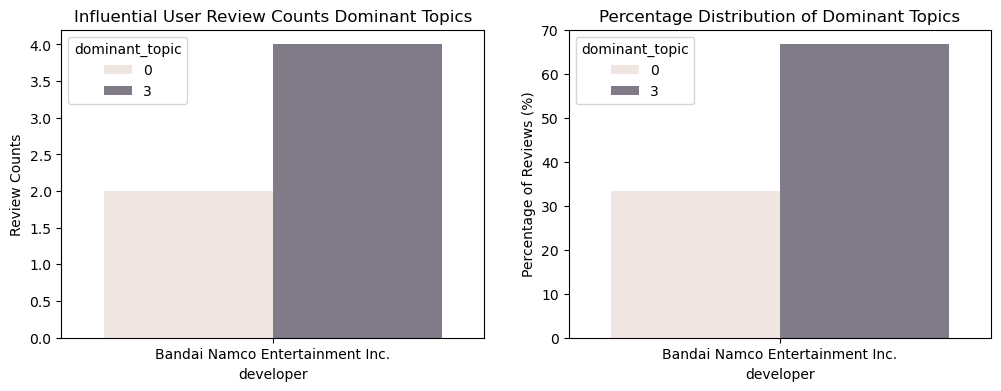

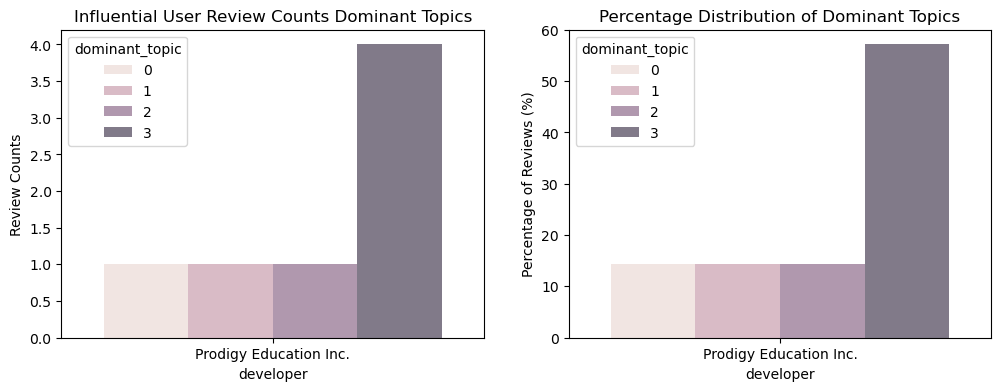

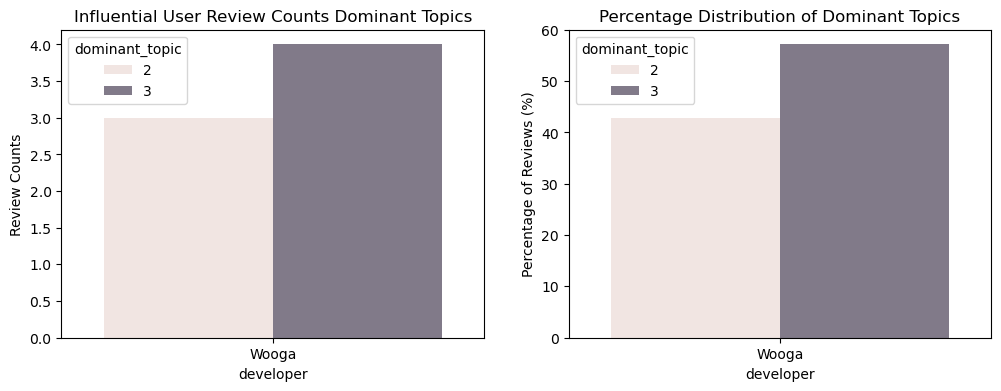

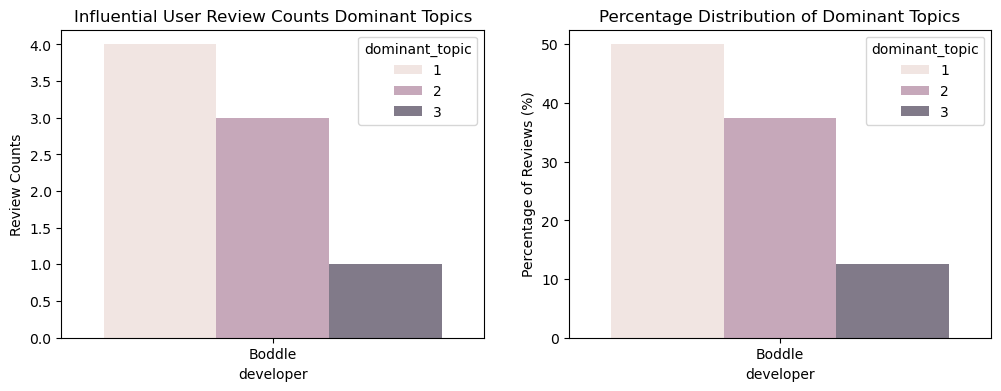

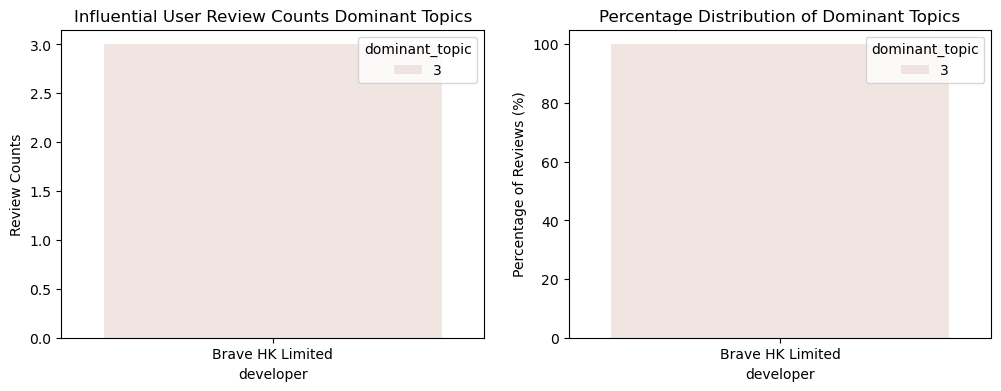

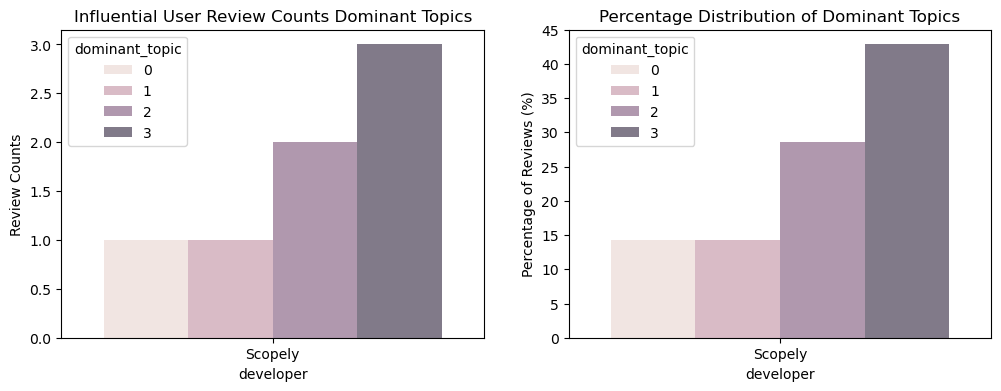

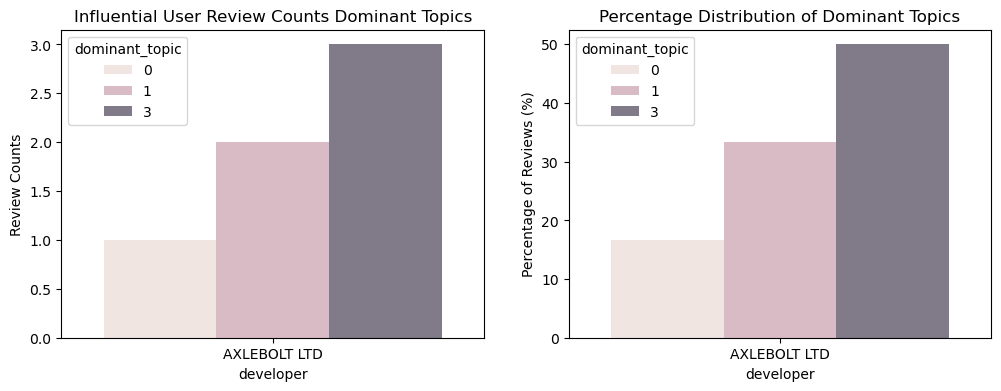

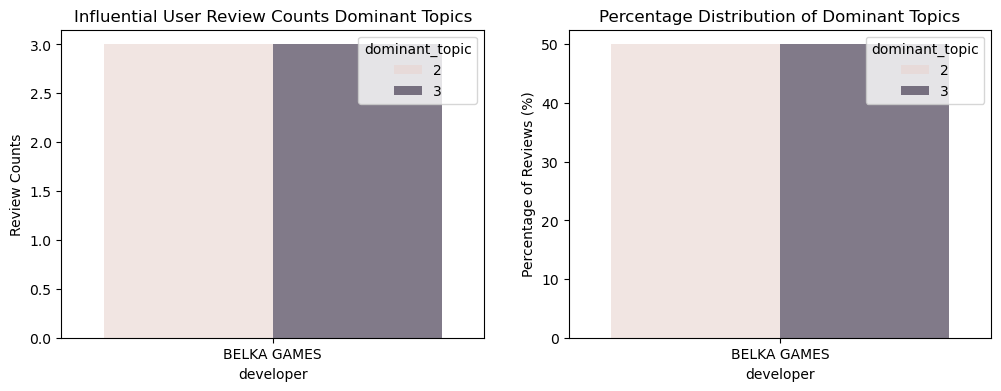

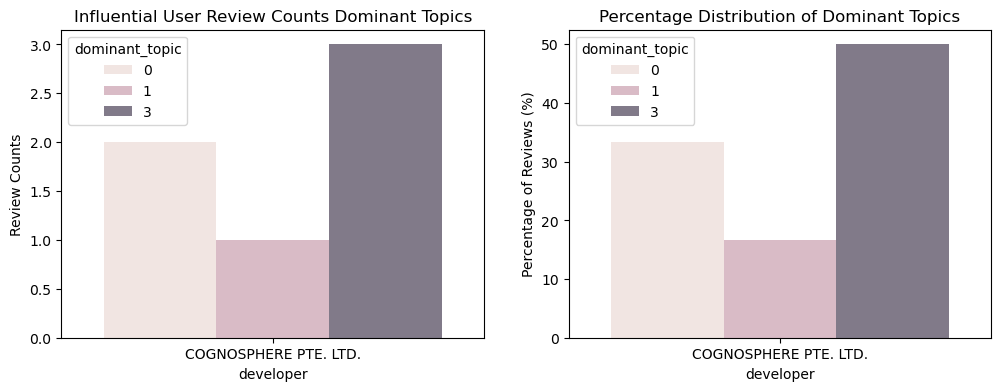

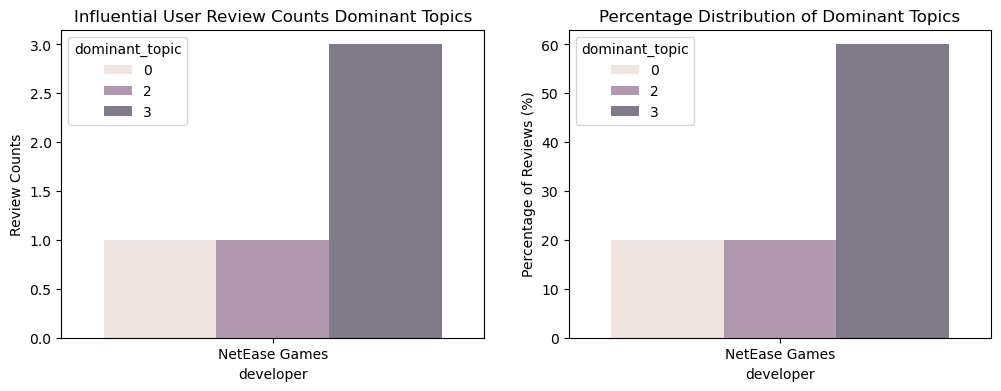

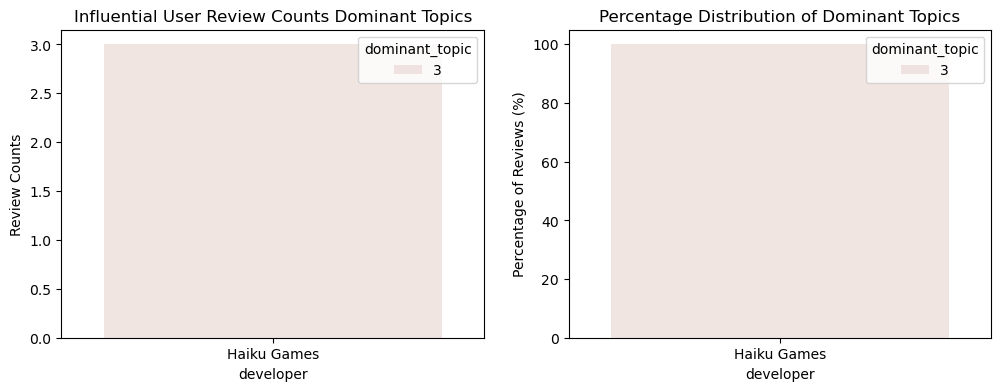

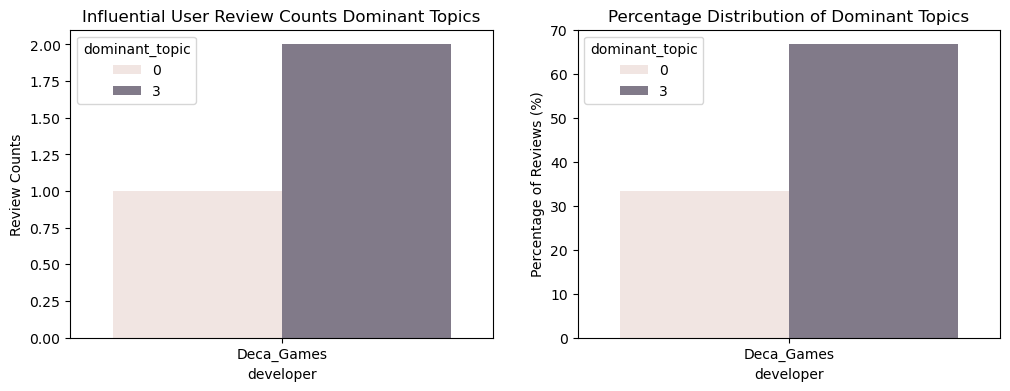

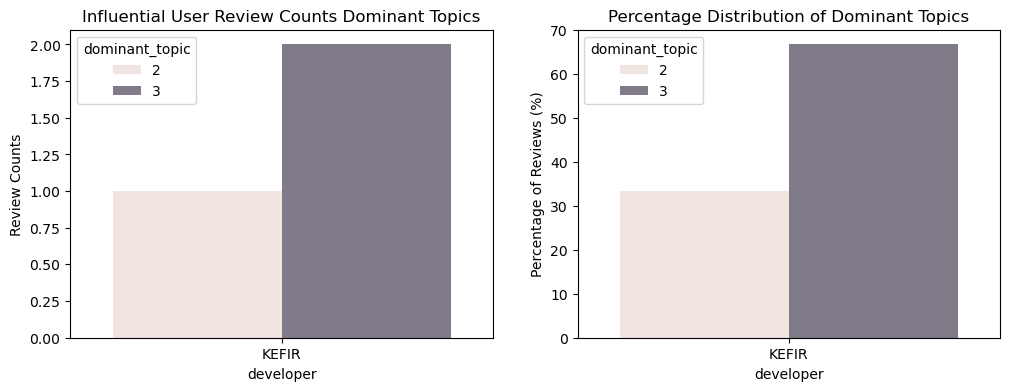

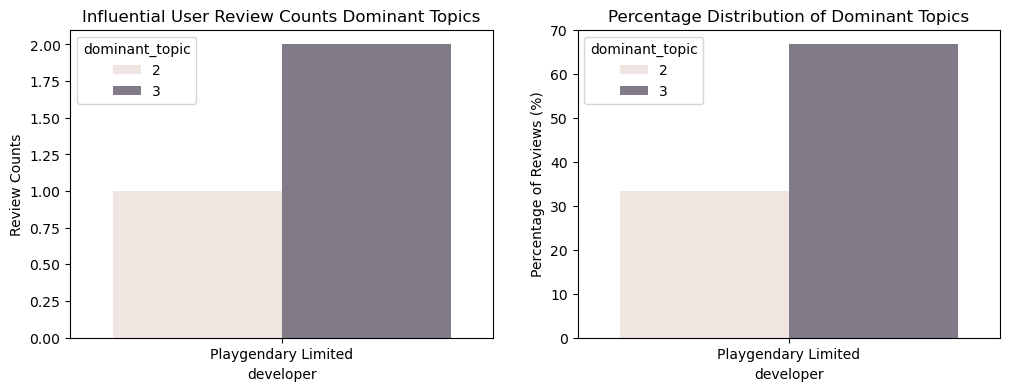

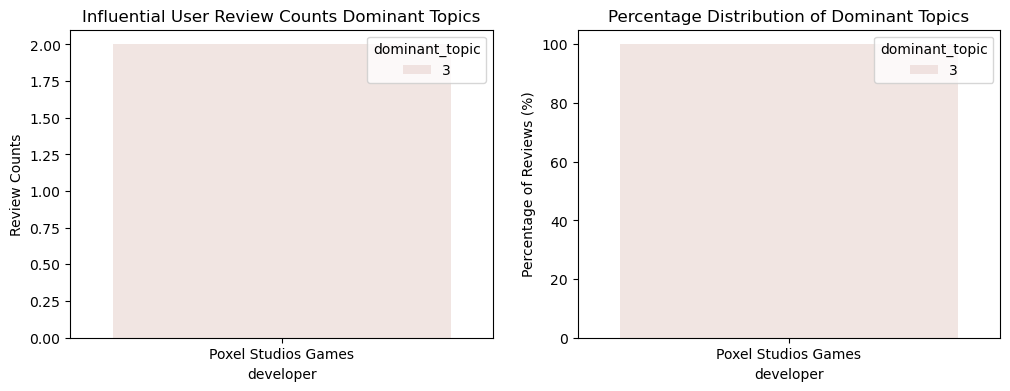

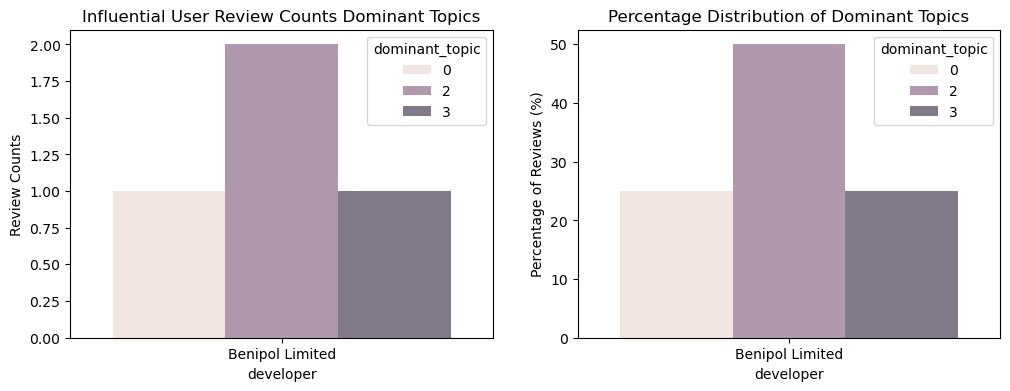

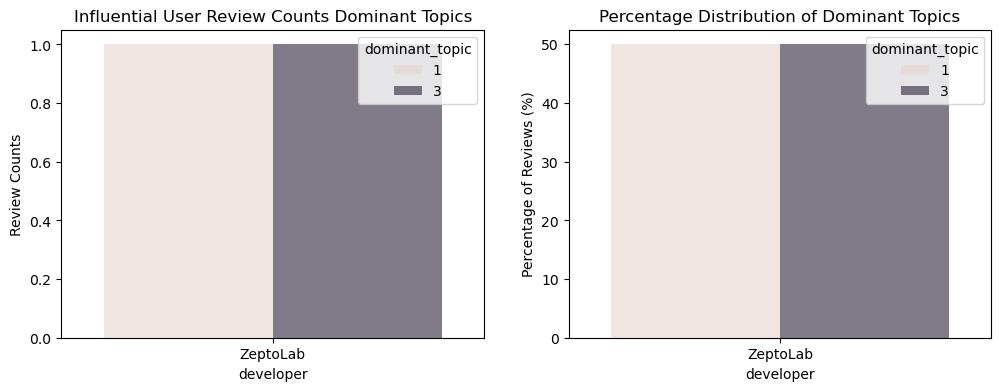

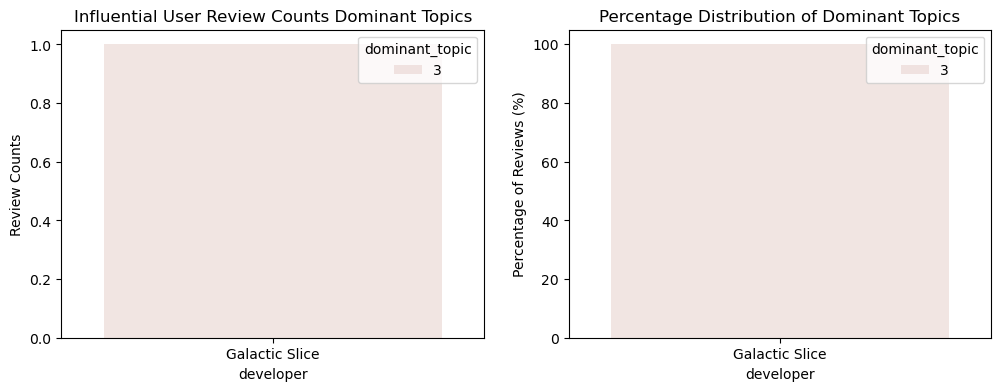

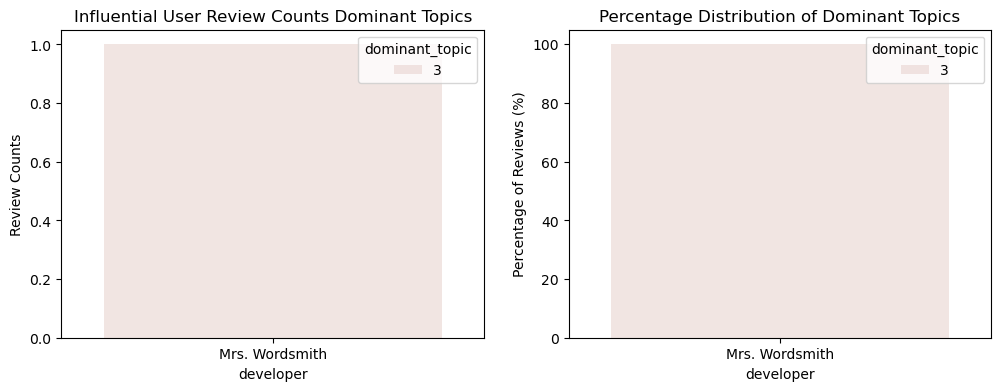

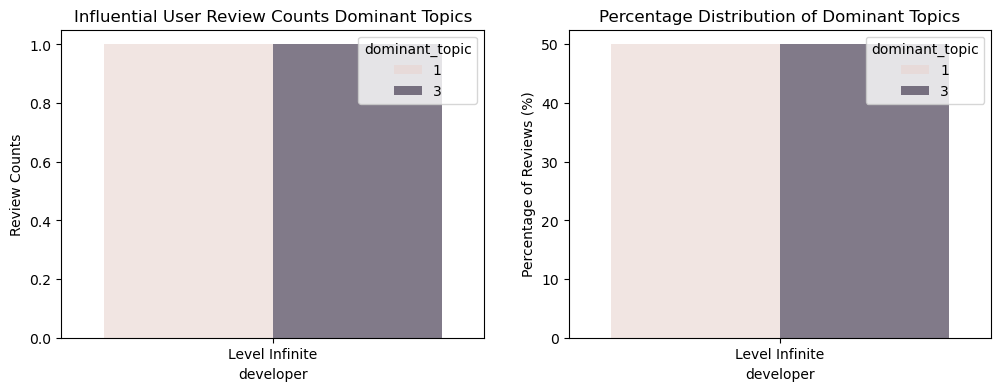

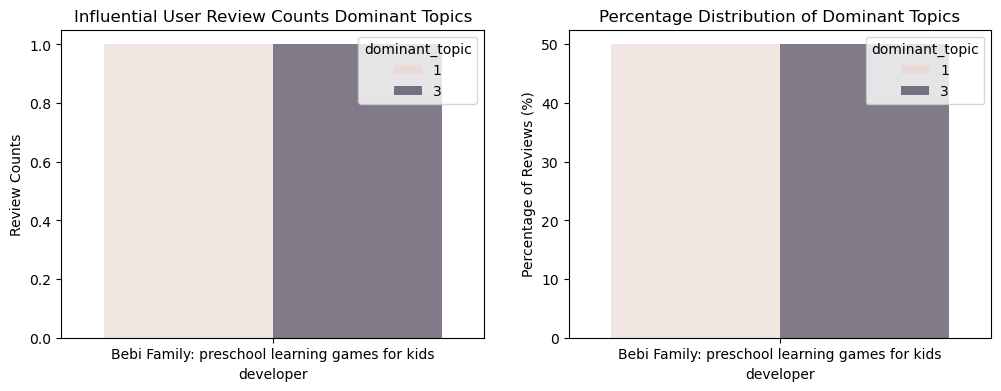

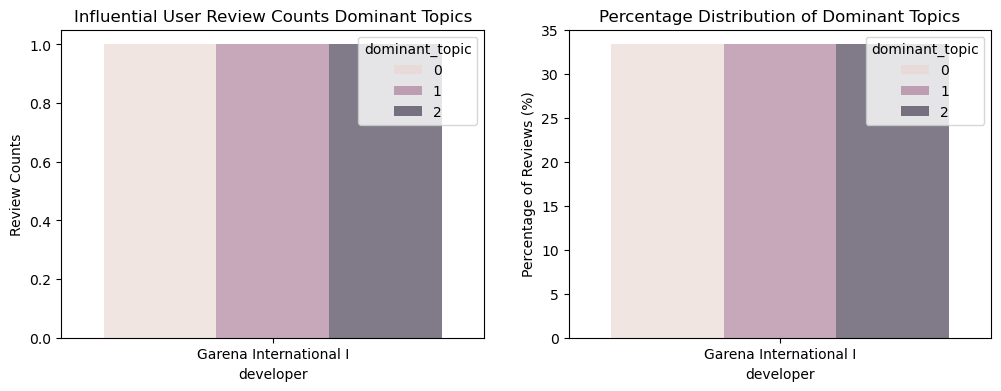

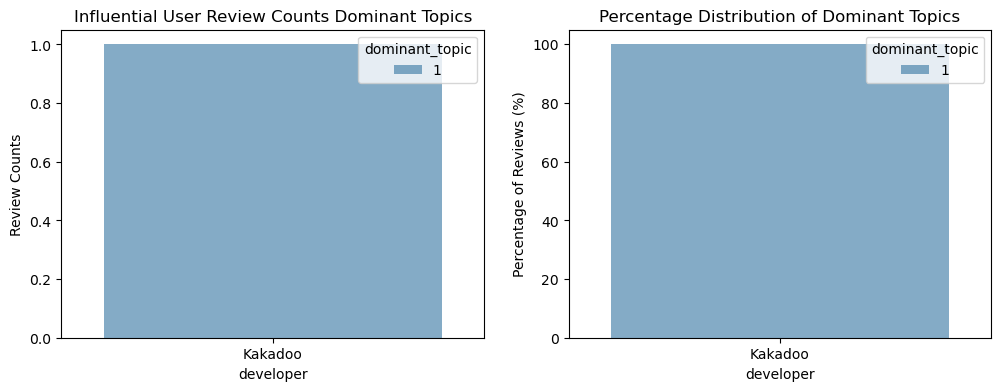

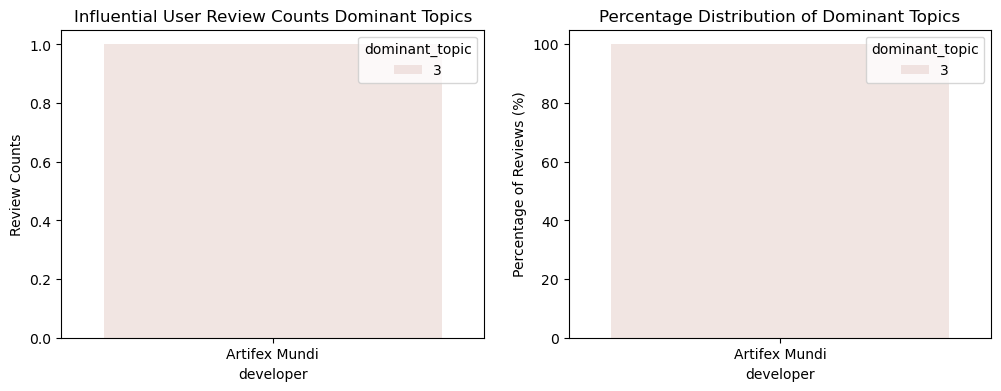

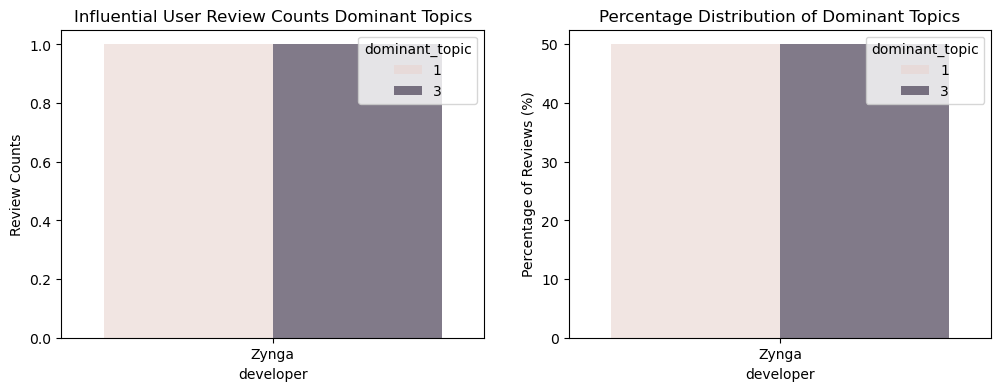

In [189]:
dev_plot = final_df[['dominant_topic','developer']].value_counts().reset_index()
dev_plot['dev_pct'] = 100*dev_plot['count']/dev_plot.groupby('developer')['count'].transform('sum')
for dev in dev_plot['developer'].unique():
    dev_plot_filter = dev_plot[dev_plot['developer'] == dev]
    fig, ax = plt.subplots(1,2, figsize = (12,4))
    g = sns.barplot(data = dev_plot_filter,  x = 'developer', y = 'count', hue = 'dominant_topic',
                    errorbar=None, alpha  = .6, ax = ax[0])
    g.set_ylabel('Review Counts')
    g.set_title(f'Influential User Review Counts Dominant Topics')
    g = sns.barplot(data = dev_plot_filter,  x = 'developer', y = 'dev_pct', hue = 'dominant_topic',
                    errorbar=None, alpha  = .6, ax = ax[1])
    g.set_ylabel('Percentage of Reviews (%)')
    g.set_title(f'Percentage Distribution of Dominant Topics')
    plt.show()

#### Questions that our Topic Modeled Dashboard for Influential Users can address.
1. Are lower-rated games associate with negative topics? 
2. Which developers receives the most for topic related to "Fix bugs, games issues, etc."?
3. For influential users with top-most likes per game, what topics dominates the most? 
4. What Topics are associated with Games that Contains Ads?

#### Q1.

Topics 0 and 2 are related to negative topics since it covers users irritation on app purchases, spends and app issues. Hence, these topics got the highest low rating which is 1/5.

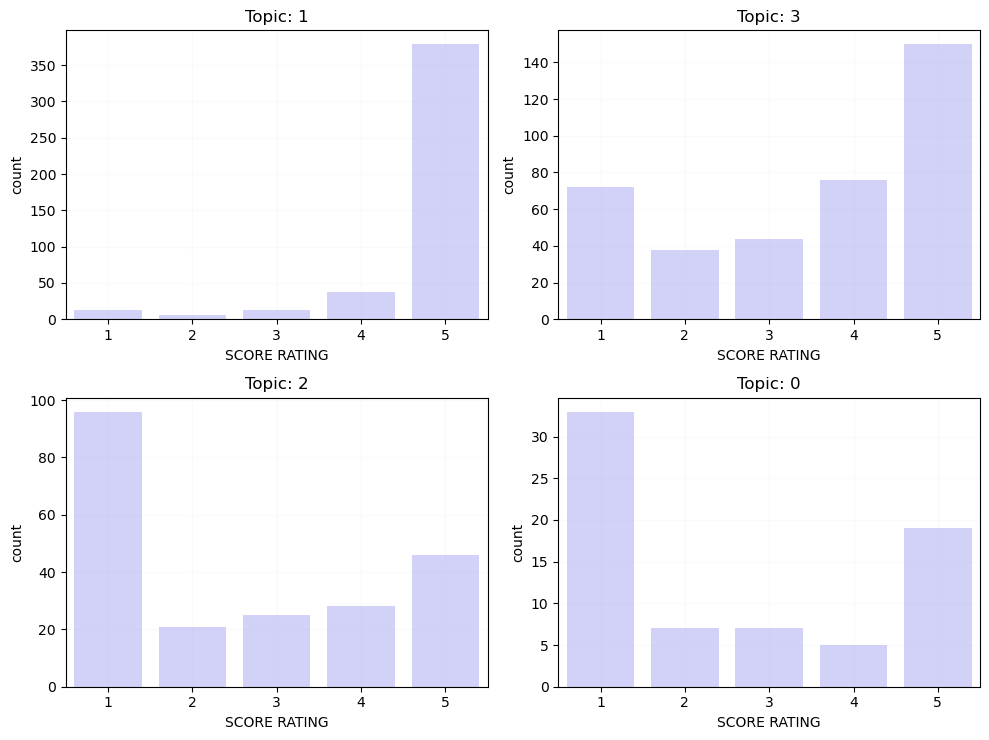

In [190]:
q1_plot = final_df[['dominant_topic', 'score_x']].value_counts().reset_index()
fig, ax = plt.subplots(2,2,figsize = (10,7.5))
for topic, axis in zip(q1_plot['dominant_topic'].unique(), ax.flatten()):
    filter_plot = q1_plot[q1_plot['dominant_topic'] == topic]
    sns.barplot(filter_plot, x = 'score_x', y = 'count', ax = axis, alpha = 0.2, color = 'blue')
    axis.set_title(f"Topic: {topic}")
    axis.set_xlabel('SCORE RATING')
    axis.set_facecolor('white')
    axis.grid(True, alpha = 0.05)
fig.tight_layout()
plt.show()


### Q2



RV AppStudios gets the most topic reviews about game bugs/issues. They create games related to children education like "alphabets", "math" and more.

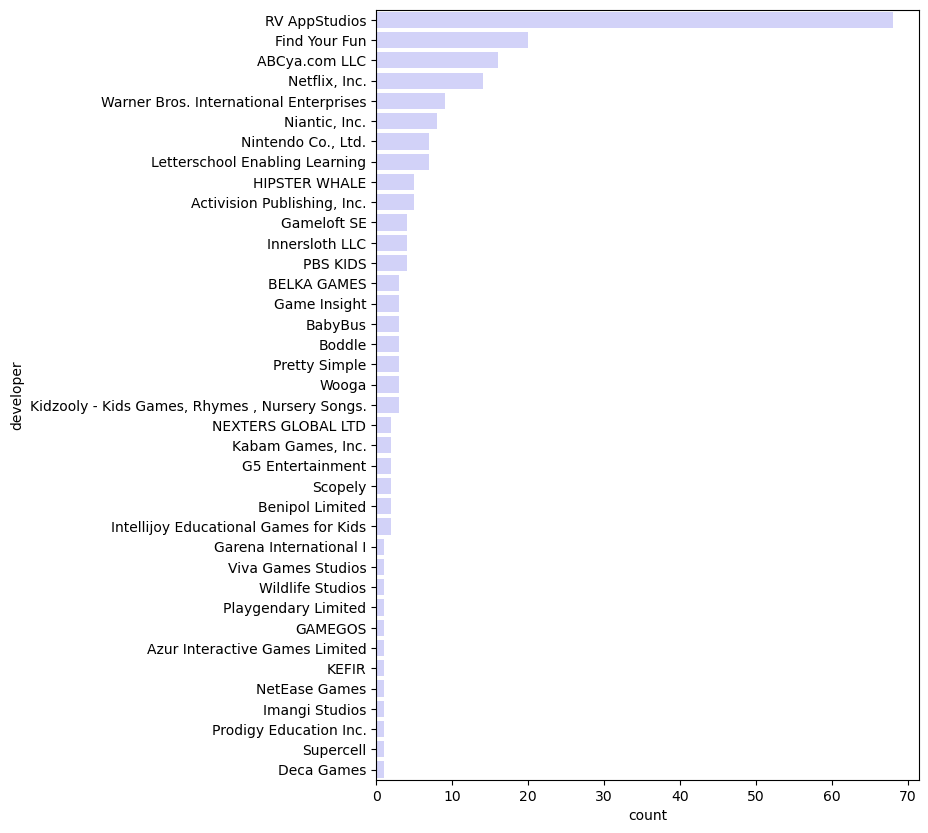

In [191]:
q2_plot = final_df.loc[final_df['dominant_topic'] == 2, 'developer'].value_counts().reset_index()
fig, ax = plt.subplots(figsize = (7, 10))
sns.barplot(q2_plot, x = 'count', y = 'developer',  alpha = 0.2, color = 'blue')
plt.show()


In [192]:
final_df.loc[(final_df['dominant_topic'] == 2) & (final_df['developer'] == 'RV AppStudios'), ['title','summary']].value_counts().index

MultiIndex([('Baby Games: Piano & Baby Phone',  'Fun baby games for kids. Play baby piano, musical instruments & nursery rhymes.'),
            ( 'Coloring Games: Color & Paint', 'Coloring book for kids! Learn Color, paint, neon drawing with educational games.'),
            (  'Kids Games: For Toddlers 3-5',                 'Amazing learning and educational games for children of all ages.'),
            ( '123 Numbers - Count & Tracing',       'Fun way for toddlers & preschoolers to learn numbers, counting, & tracing.'),
            (  'ABC Kids - Tracing & Phonics', 'Fun phonics & alphabet tracing game for toddlers, preschool & kindergarten kids!'),
            (     'Math Games: Math for Kids', 'Math Games For Kids To Learn Addition, Subtraction, Multiplication and Division.'),
            ('Math Kids: Math Games For Kids',     'Fun game for preschoolers to learn addition, subtraction, counting and math!'),
            ('Kids Toddler & Preschool Games', '15+ Toddler Games To Learn S

### Q3

For Top Most Like Games (90th percentile and above), almost 75% of the reviews pertains to topics related to Praise and Comparisons & Graphics and Gameplay

C:\Users\Mund\AppData\Local\Temp\ipykernel_24056\1379093398.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  q3_plot = 100*final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))]['dominant_topic'].value_counts()/final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))].shape[0]
C:\Users\Mund\AppData\Local\Temp\ipykernel_24056\1379093398.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  q3_plot = 100*final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))]['dominant_topic'].value_counts()/final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))].shape[0]


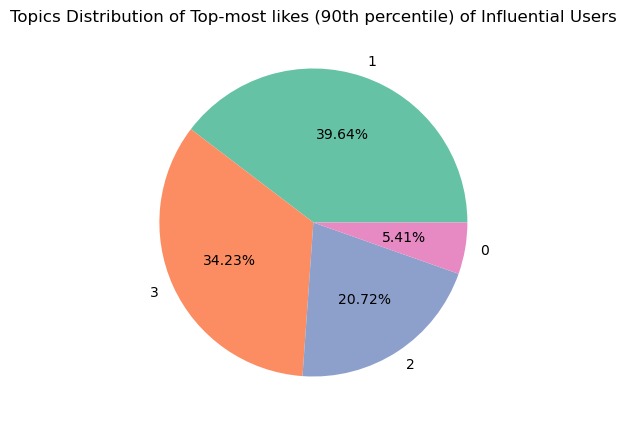

In [193]:
q3_plot = 100*final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))]['dominant_topic'].value_counts()/final_df[(combined_df['thumbsUpCount'] > final_df['thumbsUpCount'].quantile(0.90))].shape[0]
fig,ax = plt.subplots(figsize = (8,5))
plt.pie(q3_plot, labels = q3_plot.index, autopct='%0.2f%%', colors=sns.color_palette('Set2')) 
plt.title('Topics Distribution of Top-most likes (90th percentile) of Influential Users')
plt.show()

### Q4
High frequency of reviews related to Top3 (Graphics and Gameplay) are observed on Games that contains ADS

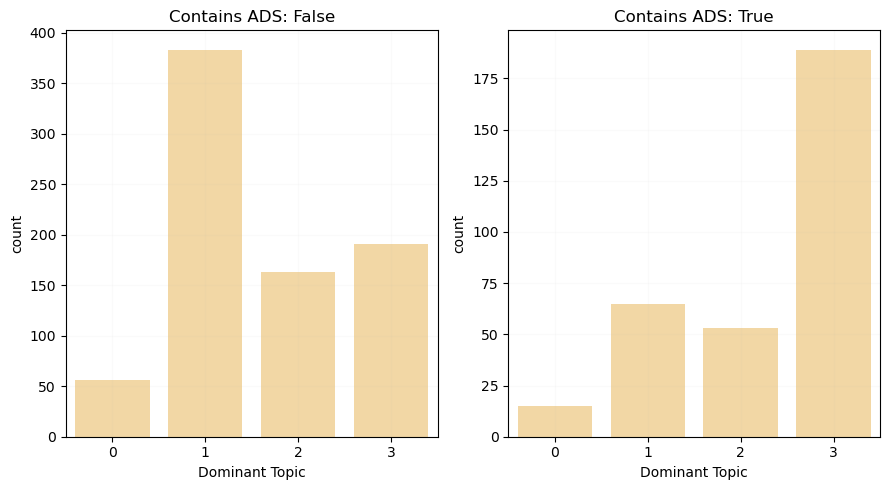

In [194]:
q4_plot = final_df[['containsAds','dominant_topic']].value_counts().reset_index()

fig, ax = plt.subplots(1,2,figsize = (9,5))
for ads_flag, axis in zip(q4_plot['containsAds'].unique(), ax.flatten()):
    filter_plot = q4_plot[q4_plot['containsAds'] == ads_flag]
    sns.barplot(filter_plot, x = 'dominant_topic', y = 'count', ax = axis, alpha = 0.4, color = 'orange')
    axis.set_title(f"Contains ADS: {ads_flag}")
    axis.set_xlabel('Dominant Topic')
    axis.set_facecolor('white')
    axis.grid(True, alpha = 0.05)
fig.tight_layout()
plt.show()

Save data for Dashboard

In [195]:
final_df.head()

content                              reviewId                                              appId           userName  score_x  thumbsUpCount                                       replyContent                reviews_NER                                  processed_reviews         0         1         2         3  dominant_topic                         title                                        description                                    descriptionHTML                                            summary     installs  minInstalls  realInstalls   score_y  ratings  reviews                        histogram  price  free currency   sale saleTime originalPrice saleText  offersIAP inAppProductPrice      developer          developerId                developerEmail             developerWebsite                                 developerAddress                                      privacyPolicy        genre           genreId  \
3   Love this game! I love this letter tracing gam...  676c0171-2ad4-46a3-b8cb-6b1bd597a37b  com.rvappstudios.abc_kids_toddler_tracing_phonics  stephanie johnson        5            128                                               None                         []  [love, game, love, letter, trace, game, beauti...  0.006103  0.569606  0.006104  0.418186               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   
17  amazing app! you can't ignore the fact they ma...  e623136b-7d0c-4714-9c8c-26904dd8b924  com.rvappstudios.abc_kids_toddler_tracing_phonics       Reem Beddawi        5            175                                               None                         []  [amazing, app, ignore, fact, make, great, app,...  0.004278  0.987166  0.004278  0.004278               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   
19  3 year old plays many of your apps he loves th...  9d391d86-096d-47c6-80a2-a896658473f9  com.rvappstudios.abc_kids_toddler_tracing_phonics       john cushard        5            225                                               None  [3 year old, 75 year old]  [year, old, play, many, app, love, learn, make...  0.003939  0.823458  0.168663  0.003939               1  ABC Kids - Tracing & Phonics  Looking for a fun, free, and simple educationa...  Looking for a fun, free, and simple educationa...  Fun phonics & alphabet tracing game for toddle...  50,000,000+     50000000      61725894  4.464314    82761     3785  [6033, 2919, 2984, 5449, 65361]    0.0  True      USD  False     None          None     None      False              None  RV AppStudios  7430005971129979939  app_support@rvappstudios.com  http://www.rvappstudios.com  848 N. Rainbow Blvd. #5467\nLas Vegas, NV 89107  http://www.rvappstudios.com/privacy_policy_ABC...  Educational  GAME_EDUCATIONAL   
21  easy to use, I love that it helps with multipl...  0d8e19f6-baf5-48b2-b332-20e169dc9f12  com.rvappstudios.abc_kids_toddler_tracing_phonics        

In [200]:
def topic_meaning(topic_num):
    if topic_num == 0:
        return 'Payment and Ads'
    elif topic_num == 1:
        return 'Praise and Comparisons'
    elif topic_num == 2:
        return 'Issues Concerns'
    elif topic_num == 3:
        return 'Graphics & Gameplay'
final_df['dominant_topic_meaning'] = final_df['dominant_topic'].apply(topic_meaning)
final_df.loc[:, ['content','userName','reviewId','title','appId','score_x','thumbsUpCount','dominant_topic','dominant_topic_meaning', 'developer', 'genre', 'contentRating', 'containsAds']].to_csv('../data/processed_streamlit/streamlit_app_data.csv')

#### THE END